In [225]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics
from numpy import unique
from sklearn.preprocessing import LabelEncoder
import matplotlib as mpl
import matplotlib.cm as cm
import warnings

warnings.filterwarnings("ignore")

In [226]:
data = pd.read_csv("/content/dataset-v2.csv")

print("Number of datapoints:", len(data))

Number of datapoints: 135


# Section 1: Data Preprocessing


In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 18 columns):
 #   Column                                                                                                        Non-Null Count  Dtype 
---  ------                                                                                                        --------------  ----- 
 0   Timestamp                                                                                                     135 non-null    object
 1   Age                                                                                                           135 non-null    object
 2   Gender                                                                                                        135 non-null    object
 3   Occupation                                                                                                    135 non-null    object
 4   Location (City/Region)                                        

In [228]:
missing_values = data.isnull().sum()
print(missing_values)

Timestamp                                                                                                        0
Age                                                                                                              0
Gender                                                                                                           0
Occupation                                                                                                       0
Location (City/Region)                                                                                           0
How often do you shop for clothing and apparel?                                                                  0
Where do you usually shop for clothing and fashion products?                                                     0
Do you prefer shopping in physical retail stores or online fashion stores?                                       0
What factors influence your choice of shopping?                                 

In [229]:
# check for non numeric values

non_numeric_columns =data.select_dtypes(exclude=['int64', 'float64']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['Timestamp', 'Age', 'Gender', 'Occupation', 'Location (City/Region)',
       'How often do you shop for clothing and apparel?',
       'Where do you usually shop for clothing and fashion products?',
       'Do you prefer shopping in physical retail stores or online fashion stores?',
       'What factors influence your choice of shopping?',
       'What types of clothing do you typically buy?',
       'Do you tend to stick with specific fashion brands when shopping?',
       'What factors influence your brand choices when shopping for clothing? ',
       'How likely are you to make a purchase if there is a special promotion or discount offered?',
       'What types of promotions or discounts do you find most appealing?',
       'How do you prefer to receive communication from fashion and apparel stores?',
       'On average, how much do you spend on fashion and apparel items per month?',
       'What payment methods do you primarily use when making fashion an

In [230]:
# drop timestamp
data=data.drop(['Timestamp'],axis=1)

In [231]:
# preprocessing user locations (summerize this)
data['Location (City/Region)']=data['Location (City/Region)'].str.strip()
data['Location (City/Region)']=data['Location (City/Region)'].replace(['piliyandala','piliyandala.', 'Piliyandala / buddist'],'Piliyandala')
data['Location (City/Region)']=data['Location (City/Region)'].replace(['colombo grandpass','Kotahena', 'Kirulapana'],'Colombo')
data['Location (City/Region)']=data['Location (City/Region)'].replace('Colombo 05','Colombo')
data['Location (City/Region)']=data['Location (City/Region)'].replace(['Singapore',
       'Ella', 'Bandaragama', 'Kurunegala', 'Mount lavinia',
        'Al khail gate', 'sri lanka , sinhala',
       'Battaramulla', 'Kaluthara', 'Melbourne, Australia', 'Ratmalana',
       'Awissawella', 'Galle', 'Mathara', 'Nugegoda', 'Mulleriyawa New Town', 'Horana', 'Rathnapura', 'Kegalle', 'Kaduwela', 'Kohuwala', 'Gampaha', 'Balapitiya', 'Thalawathugoda', 'Rajagiriya', 'Panadura',  'Kandy', 'Wattala', 'Ratnapura', 'Panagoda'],'Other')
data['Location (City/Region)'].value_counts()

Piliyandala    35
Other          32
Colombo        30
Homagama       17
Maharagama     10
Kottawa         9
Kotte           2
Name: Location (City/Region), dtype: int64

In [232]:
# rename column names to short ones
data=data.rename({
    'Location (City/Region)':'Location',
    'How often do you shop for clothing and apparel?':'Shopping Frequency',
    'Where do you usually shop for clothing and fashion products?':'Shopping Methods',
    'Do you prefer shopping in physical retail stores or online fashion stores?':'Online, instore preferences',
    'What factors influence your choice of shopping?':'Influence Factors',
    'What types of clothing do you typically buy?':'Types of Clothing',
    'Do you tend to stick with specific fashion brands when shopping?':'Brand Preference',
    'What factors influence your brand choices when shopping for clothing? ':'Brand Choice Factors',
    'How likely are you to make a purchase if there is a special promotion or discount offered?':'Likeliness of Promotion or Discount',
    'What types of promotions or discounts do you find most appealing?':'Preferred Types of Promotions or Discounts',
    'How do you prefer to receive communication from fashion and apparel stores?':'Communication Methods', # to methods
    'On average, how much do you spend on fashion and apparel items per month?':'Average Spent',
    'What payment methods do you primarily use when making fashion and apparel purchases?':'Payment Methods',
    'Any additional comments or thoughts you would like to share about your shopping preferences and experiences?':'Comments'
}, axis='columns')

In [233]:
# remove comments column
data = data.drop(['Comments'],axis=1)

In [234]:
# export the pre-processed dataset
data.to_csv("/content/pp-dataset.csv")

In [235]:
raw_data = data.copy()
data.columns

Index(['Age', 'Gender', 'Occupation', 'Location', 'Shopping Frequency',
       'Shopping Methods', 'Online, instore preferences', 'Influence Factors',
       'Types of Clothing', 'Brand Preference', 'Brand Choice Factors',
       'Likeliness of Promotion or Discount',
       'Preferred Types of Promotions or Discounts', 'Communication Methods',
       'Average Spent', 'Payment Methods'],
      dtype='object')

In [236]:
def pp_types_of_clothing(x):
  x = x.replace('(e.g.bags,jewellary', "")
  x = x.split(",")
  return x

In [237]:
# split the multiple choice questions to list
data['Influence Factors'] = data['Influence Factors'].apply(lambda x: x.split(","))
data['Types of Clothing'] = data['Types of Clothing'].apply(pp_types_of_clothing)
data['Brand Choice Factors'] = data['Brand Choice Factors'].apply(lambda x: x.split(","))
data['Preferred Types of Promotions or Discounts'] = data['Preferred Types of Promotions or Discounts'].apply(lambda x: x.split(","))
data['Payment Methods'] = data['Payment Methods'].apply(lambda x: x.split(","))
data['Shopping Methods'] = data['Shopping Methods'].apply(lambda x: x.split(","))
data['Communication Methods'] = data['Communication Methods'].apply(lambda x: x.split(","))

In [238]:
# data['Shopping Methods'] = data['Shopping Methods'].apply(lambda x: x.split(","))

def make_boolean(x):
  x = x.split(",")
  return True if x[0].strip() == "Yes" else False

data['Brand Preference'] = data['Brand Preference'].apply(make_boolean)

In [239]:
# meter
# very likely => 5
# likely => 4
# neutral => 3
# unlikely => 2
# very unlikely => 1

def make_likeliness(x):
  x = x.strip()
  return 5 if x == "Very likely" else 4 if x == "Likely" else 3 if x == "Neutral" else 2 if x == "Unlikely" else 1 if x == "Very unlikely"  else 0

data['Likeliness of Promotion or Discount'] = data['Likeliness of Promotion or Discount'].apply(make_likeliness)

# Section 2: Visualizations

In [240]:
data.head()

,Age,Gender,Occupation,Location,Shopping Frequency,Shopping Methods,"Online, instore preferences",Influence Factors,Types of Clothing,Brand Preference,Brand Choice Factors,Likeliness of Promotion or Discount,Preferred Types of Promotions or Discounts,Communication Methods,Average Spent,Payment Methods
0,18-24,Female,Student/Undergraduate,Colombo,Rarely,"[Physical retail stores, Online fashion store...",Physical retail stores,"[Availability of a wide range of options, Com...",[Casual Wear],False,"[Price and affordability, Trendiness and styl...",3,"[Percentage discounts, Seasonal sales, Other]","[SMS/text messages, Social media updates, In...",Less than Rs.2000,[Cash]
1,18-24,Female,Student/Undergraduate,Colombo,Once a month,"[Physical retail stores, Online fashion store...",Depends on the occasion,"[Convenience, Availability of a wide range of...",[Casual Wear],True,"[Brand reputation and quality, Price and affo...",3,"[Percentage discounts, Buy-one-get-one(BOGO) ...","[Social media updates, In store notifications...",Rs.2000-Rs.5000,[Credit/Debit Card]
2,18-24,Female,Student/Undergraduate,Piliyandala,Once a month,"[Physical retail stores, Online fashion store...",Depends on the occasion,"[Convenience, Availability of a wide range of...",[Casual Wear],False,"[Brand reputation and quality, Price and affo...",5,"[Percentage discounts, Seasonal sales, Free ...","[Email newsletters, SMS/text messages, Socia...",Rs.2000-Rs.5000,[Cash]
3,18-24,Female,Student/Undergraduate,Piliyandala,Rarely,"[Physical retail stores, Department stores]",Equally prefer both,"[Availability of a wide range of options, Per...","[Casual Wear, Accessories]",False,"[Price and affordability, Trendiness and styl...",4,"[Percentage discounts, Buy-one-get-one(BOGO) ...","[SMS/text messages, Social media updates, In...",Less than Rs.2000,"[Credit/Debit Card, Cash]"
4,25-30,Female,"Professional (e.g., Engineer, Doctor, Lawyer, ...",Colombo,Multiple times a month,"[Physical retail stores, Online fashion store...",Depends on the occasion,"[Convenience, Personalized shopping experienc...","[Casual Wear, Formal Wear]",False,"[Brand reputation and quality, Price and affo...",5,"[Percentage discounts, Seasonal sales, Free ...","[Email newsletters, SMS/text messages, Socia...",Rs.5000-Rs.10000,[Credit/Debit Card]


<Axes: ylabel='Gender'>

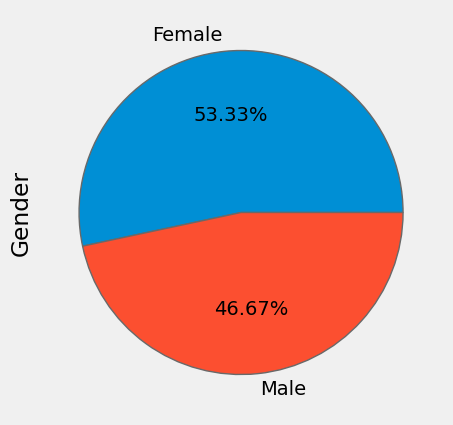

In [241]:
# Gender Difference
gender_count = data.groupby('Gender')['Gender'].count()
gender_count.plot.pie(y='mass', figsize=(5, 5),  autopct='%.2f%%')

In [242]:
data.groupby('Location')["Gender"].count()

Location
Colombo        30
Homagama       17
Kottawa         9
Kotte           2
Maharagama     10
Other          32
Piliyandala    35
Name: Gender, dtype: int64

<Axes: ylabel='Location'>

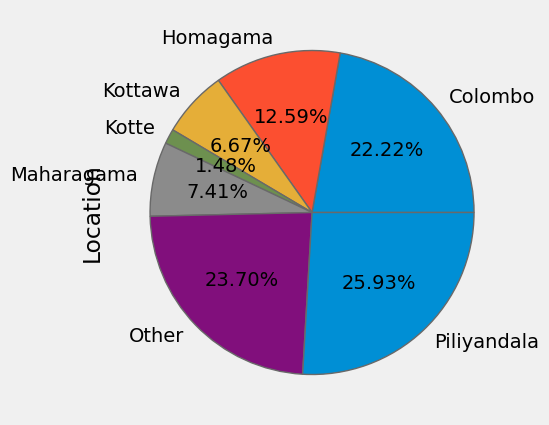

In [243]:
# Location Difference
location_count = data.groupby('Location')['Location'].count()
location_count.plot.pie(y='mass', figsize=(5, 5),  autopct='%.2f%%')

<Axes: ylabel='Occupation'>

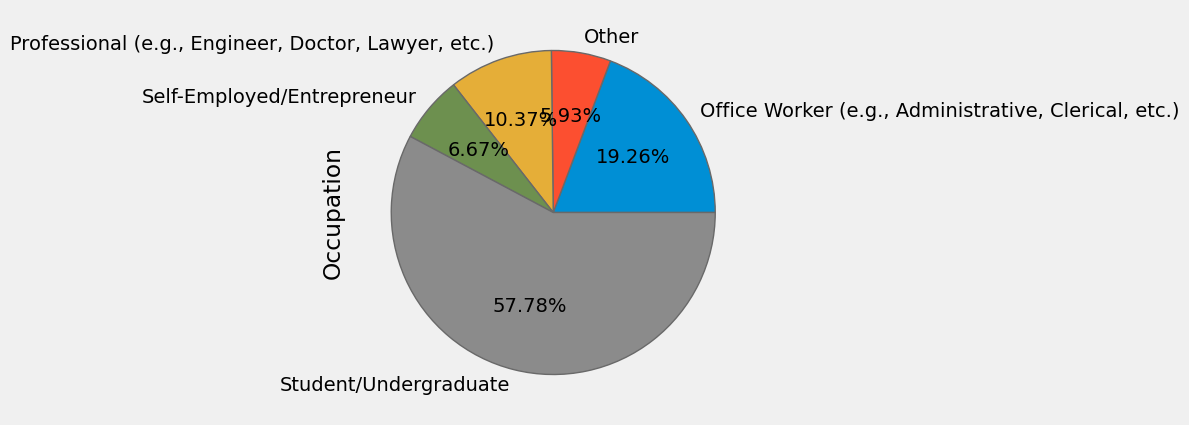

In [244]:
# Occupation Difference
occupation_count = data.groupby('Occupation')['Occupation'].count()
occupation_count.plot.pie(y='mass', figsize=(5, 5),  autopct='%.2f%%')

<Axes: ylabel='Age'>

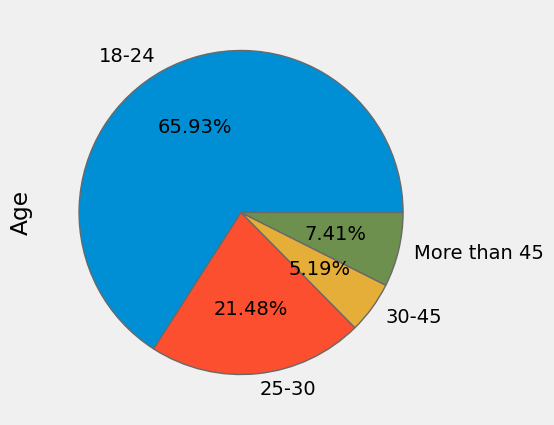

In [245]:
# Age Difference
age_count = data.groupby('Age')['Age'].count()
age_count.plot.pie(y='mass', figsize=(5, 5),  autopct='%.2f%%')

<Axes: ylabel='Online, instore preferences'>

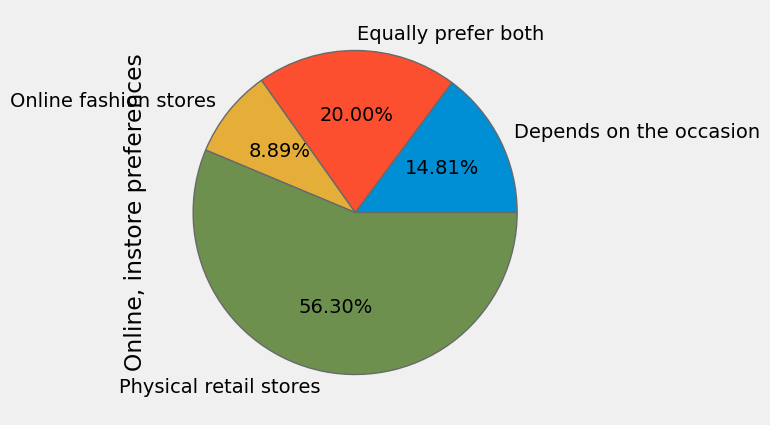

In [246]:
# Online, instore preferences

online_instore_count = data.groupby('Online, instore preferences')['Online, instore preferences'].count()
online_instore_count.plot.pie(y='mass', figsize=(5, 5),  autopct='%.2f%%')

<Axes: ylabel='Average Spent'>

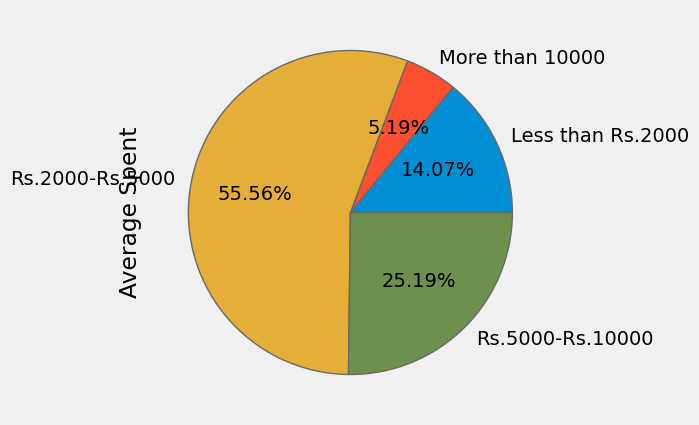

In [247]:
# Average Spent

avg_spent_count = data.groupby('Average Spent')['Average Spent'].count()
avg_spent_count.plot.pie(y='mass', figsize=(5, 5),  autopct='%.2f%%')

<Axes: ylabel='Likeliness of Promotion or Discount'>

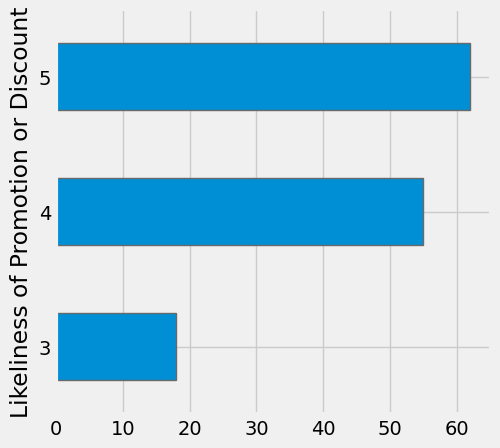

In [248]:
# Likeliness of Promotion or Discount

likeliness_scale_count = data.groupby('Likeliness of Promotion or Discount')['Likeliness of Promotion or Discount'].count()

likeliness_scale_count.plot.barh(y='mass', figsize=(5, 5))

In [249]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Age                                         135 non-null    object
 1   Gender                                      135 non-null    object
 2   Occupation                                  135 non-null    object
 3   Location                                    135 non-null    object
 4   Shopping Frequency                          135 non-null    object
 5   Shopping Methods                            135 non-null    object
 6   Online, instore preferences                 135 non-null    object
 7   Influence Factors                           135 non-null    object
 8   Types of Clothing                           135 non-null    object
 9   Brand Preference                            135 non-null    bool  
 10  Brand Choice Factors      

# Section 3: Data Encoding

In [250]:
data.index = range(len(data))

In [251]:
# preprocess lists

# as mentioned in pre-processing here we take the columns that has lists and put that list items in to the columns by appending the item name to the column name. and if that item is in that row's list we make that column 1 and if it's not present we make it 0.
# It's similler to the onehot encoding.
# refer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

def get_uniques(x):
  columns = []
  for _x in x:
    for __x in _x:
      __x = __x.strip()
      if(not columns.count(__x)):
        columns.append(__x)
  return columns

def add_columns(new_columns, prefix):
  for nc in new_columns:
    data[prefix + "_"+ nc] = 0

def fill(prefix):
  for i in range(len(data[prefix])):
    for __x in data.loc[i, prefix]:
      __x = __x.strip()
      data[prefix + "_"+ __x][i] = 1

def preprocess_lists(column_name):
  uniques = get_uniques(data[column_name])
  add_columns(uniques, column_name)
  fill(column_name)
  data.drop([column_name], axis=1, inplace=True)


preprocess_lists('Types of Clothing')
preprocess_lists('Shopping Methods')
preprocess_lists('Influence Factors')
preprocess_lists('Brand Choice Factors')
preprocess_lists('Preferred Types of Promotions or Discounts')
preprocess_lists('Communication Methods')
preprocess_lists('Payment Methods')

data

,Age,Gender,Occupation,Location,Shopping Frequency,"Online, instore preferences",Brand Preference,Likeliness of Promotion or Discount,Average Spent,Types of Clothing_Casual Wear,...,Preferred Types of Promotions or Discounts_Loyalty rewards programs,Communication Methods_SMS/text messages,Communication Methods_Social media updates,Communication Methods_In store notifications,Communication Methods_Leaflets,Communication Methods_Email newsletters,Payment Methods_Cash,Payment Methods_Credit/Debit Card,Payment Methods_Mobile Payment Apps,Payment Methods_Online Payment Platforms
0,18-24,Female,Student/Undergraduate,Colombo,Rarely,Physical retail stores,False,3,Less than Rs.2000,1,...,0,1,1,1,0,0,1,0,0,0
1,18-24,Female,Student/Undergraduate,Colombo,Once a month,Depends on the occasion,True,3,Rs.2000-Rs.5000,1,...,0,0,1,1,1,0,0,1,0,0
2,18-24,Female,Student/Undergraduate,Piliyandala,Once a month,Depends on the occasion,False,5,Rs.2000-Rs.5000,1,...,0,1,1,0,0,1,1,0,0,0
3,18-24,Female,Student/Undergraduate,Piliyandala,Rarely,Equally prefer both,False,4,Less than Rs.2000,1,...,0,1,1,1,0,0,1,1,0,0
4,25-30,Female,"Professional (e.g., Engineer, Doctor, Lawyer, ...",Colombo,Multiple times a month,Depends on the occasion,False,5,Rs.5000-Rs.10000,1,...,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,18-24,Female,Student/Undergraduate,Colombo,Once a month,Physical retail stores,True,5,Rs.2000-Rs.5000,1,...,1,1,1,0,0,1,0,1,0,0
131,18-24,Female,Student/Undergraduate,Piliyandala,Multiple times a month,Equally prefer both,False,5,Rs.2000-Rs.5000,1,...,0,1,1,1,0,0,1,0,0,0
132,18-24,Female,Student/Undergraduate,Maharagama,Once a month,Physical retail stores,False,4,Rs.2000-Rs.5000,1,...,0,1,1,1,0,0,1,1,1,1
133,18-24,Male,"Office Worker (e.g., Administrative, Clerical,...",Other,Multiple times a month,Depends on the occasion,False,4,Less than Rs.2000,1,...,0,1,1,0,1,0,1,1,0,0


In [252]:
# then we label encode the other columns that has string values.

from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Gender', 'Age']
label_encoder = LabelEncoder()

data[['Age', 'Gender', 'Occupation', 'Location', 'Shopping Frequency','Online, instore preferences',
       'Average Spent', 'Brand Preference']]= data[['Age', 'Gender', 'Occupation', 'Location', 'Shopping Frequency', 'Online, instore preferences',
       'Average Spent', 'Brand Preference']].apply(LabelEncoder().fit_transform)
data

,Age,Gender,Occupation,Location,Shopping Frequency,"Online, instore preferences",Brand Preference,Likeliness of Promotion or Discount,Average Spent,Types of Clothing_Casual Wear,...,Preferred Types of Promotions or Discounts_Loyalty rewards programs,Communication Methods_SMS/text messages,Communication Methods_Social media updates,Communication Methods_In store notifications,Communication Methods_Leaflets,Communication Methods_Email newsletters,Payment Methods_Cash,Payment Methods_Credit/Debit Card,Payment Methods_Mobile Payment Apps,Payment Methods_Online Payment Platforms
0,0,0,4,0,3,3,0,3,0,1,...,0,1,1,1,0,0,1,0,0,0
1,0,0,4,0,2,0,1,3,2,1,...,0,0,1,1,1,0,0,1,0,0
2,0,0,4,6,2,0,0,5,2,1,...,0,1,1,0,0,1,1,0,0,0
3,0,0,4,6,3,1,0,4,0,1,...,0,1,1,1,0,0,1,1,0,0
4,1,0,2,0,1,0,0,5,3,1,...,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0,0,4,0,2,3,1,5,2,1,...,1,1,1,0,0,1,0,1,0,0
131,0,0,4,6,1,1,0,5,2,1,...,0,1,1,1,0,0,1,0,0,0
132,0,0,4,4,2,3,0,4,2,1,...,0,1,1,1,0,0,1,1,1,1
133,0,1,0,5,1,0,0,4,0,1,...,0,1,1,0,1,0,1,1,0,0


In [253]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = mpl.colormaps["Spectral"]
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
    plt.show()

# Section 4: Customer Segmentaion using K Means

In [254]:
def graph_comp(matrix, clusters, n_clusters):
  sample_silhouette_values = silhouette_samples(matrix, clusters)
  graph_component_silhouette(n_clusters, [-0.1, 1], len(matrix), sample_silhouette_values, clusters)

In [255]:
# Define function to benchmarking the performance of the different number of clusters

def benchmark_K_means(X, max_n_clusters, draw_graph_comp=False):
  wcss = [] # withing cluster sum of squares
  silhouette = []
  for i in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=4, n_init="auto")
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    clusters = kmeans.predict(X)
    if draw_graph_comp:
      print("N clusters:" + str(i))
      graph_comp(data, clusters, i)
      print("---")
    silhouette_avg = silhouette_score(X, clusters)
    silhouette.append(silhouette_avg)

  plt.plot(range(2, max_n_clusters), wcss)
  plt.title('The Elbow Method')
  plt.xlabel('no of clusters')
  plt.ylabel('wcss')
  plt.show()

  plt.plot(range(2, max_n_clusters), silhouette)
  plt.title('Silhouette Avg')
  plt.xlabel('no of clusters')
  plt.ylabel('Avg')
  plt.show()
  print(wcss)
  print(silhouette)

N clusters:2


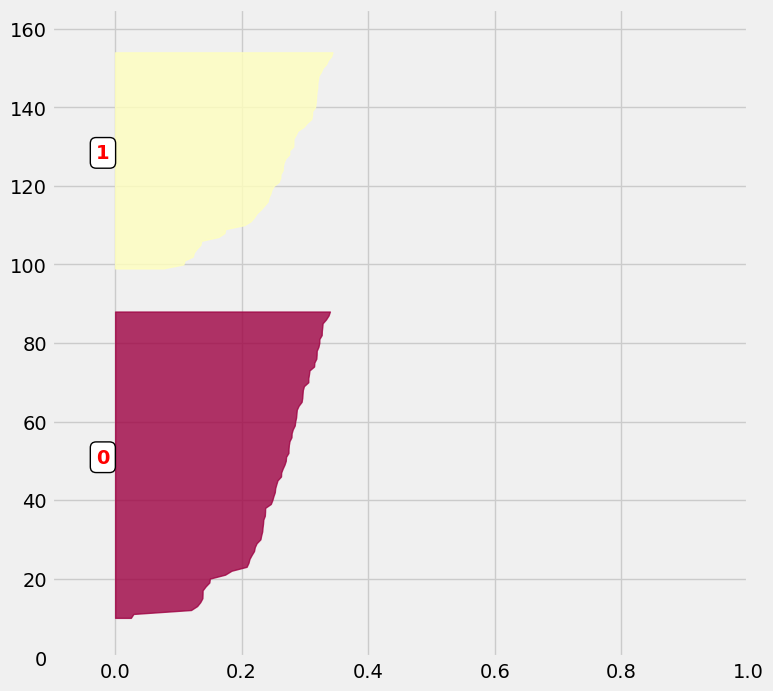

---
N clusters:3


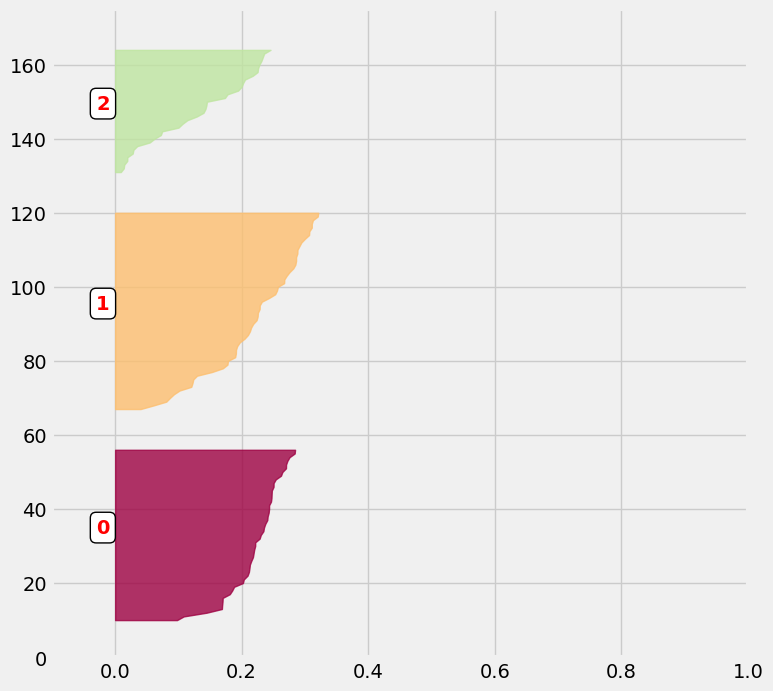

---
N clusters:4


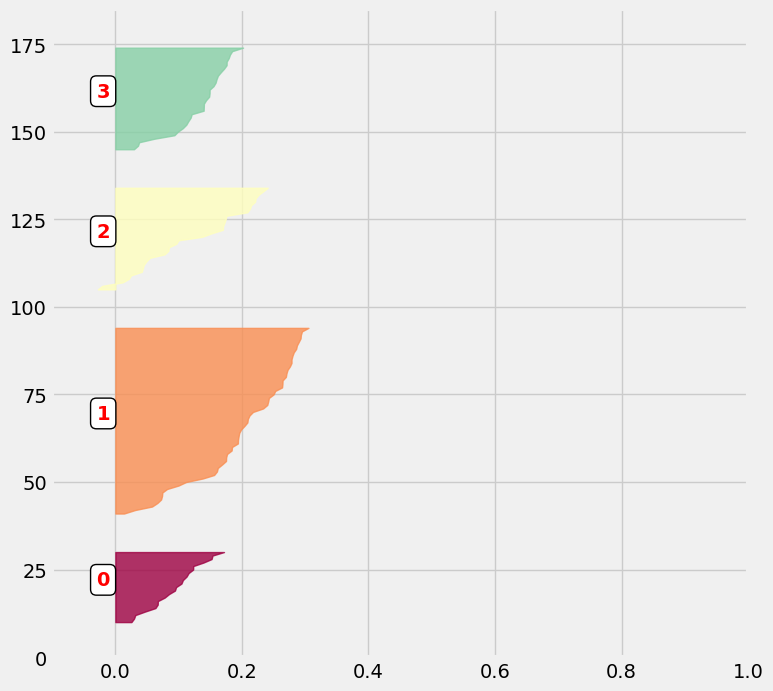

---
N clusters:5


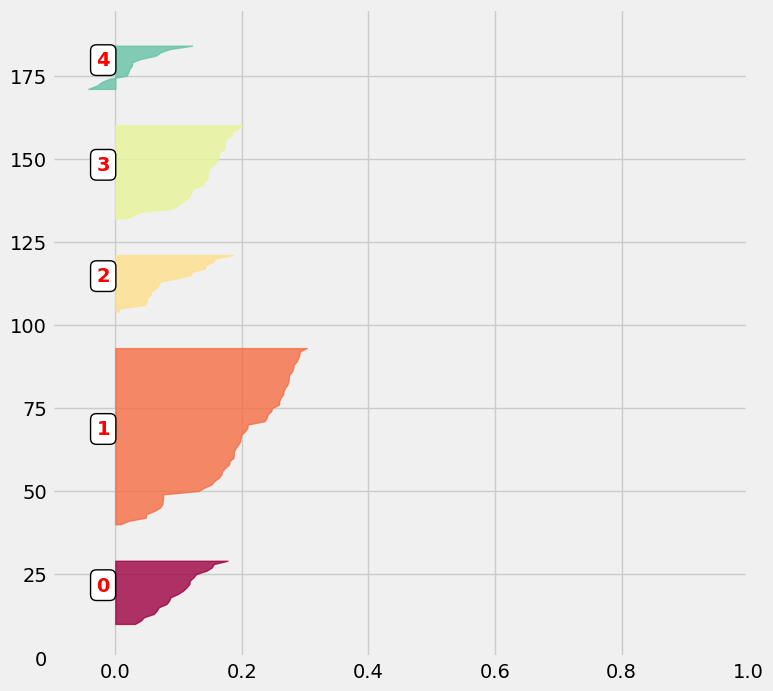

---
N clusters:6


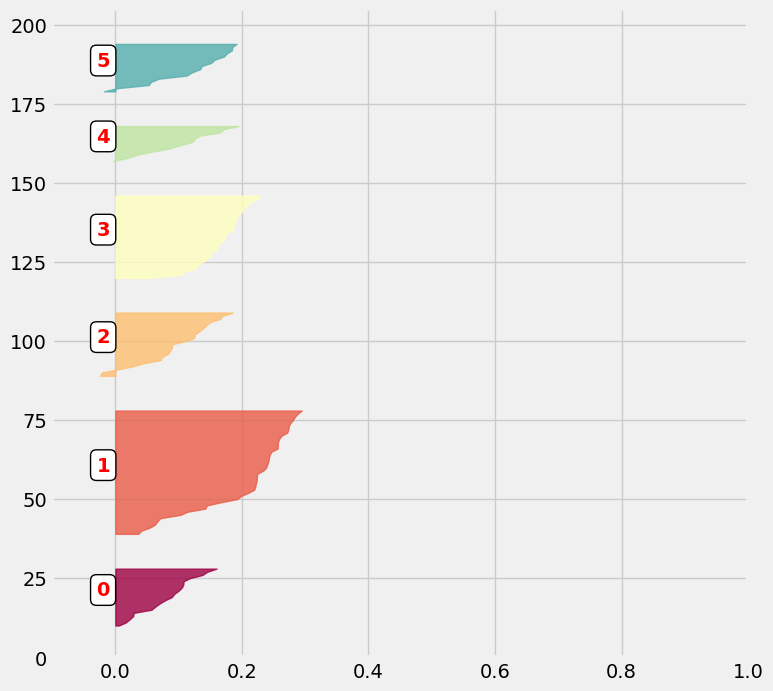

---
N clusters:7


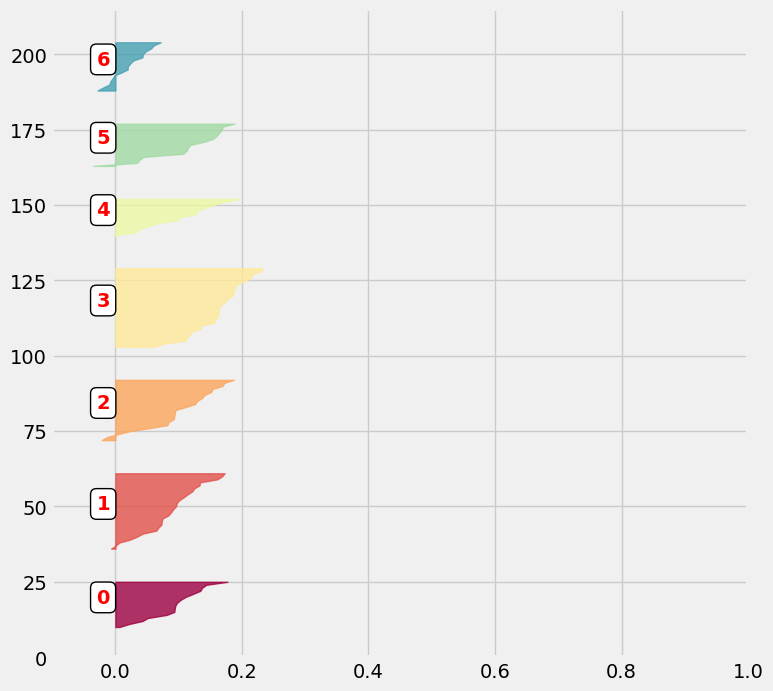

---
N clusters:8


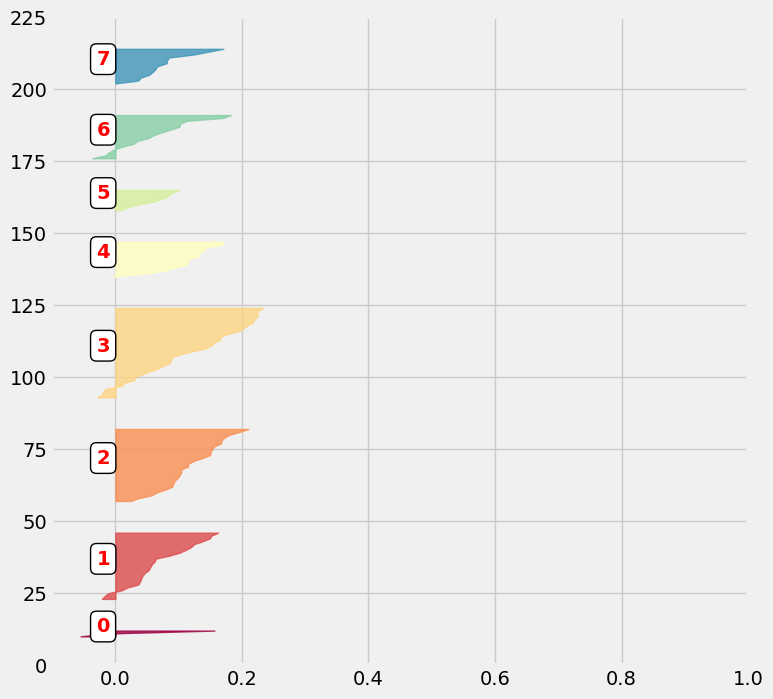

---
N clusters:9


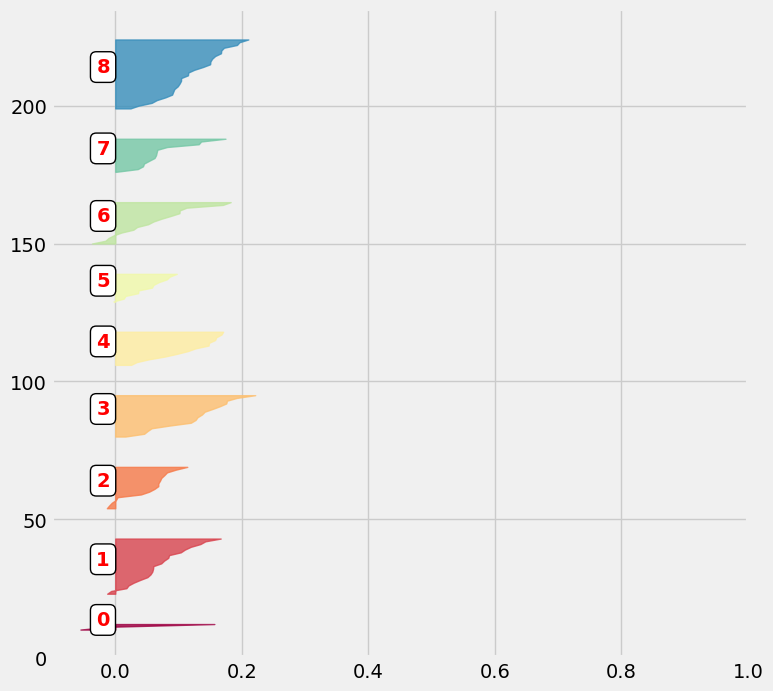

---
N clusters:10


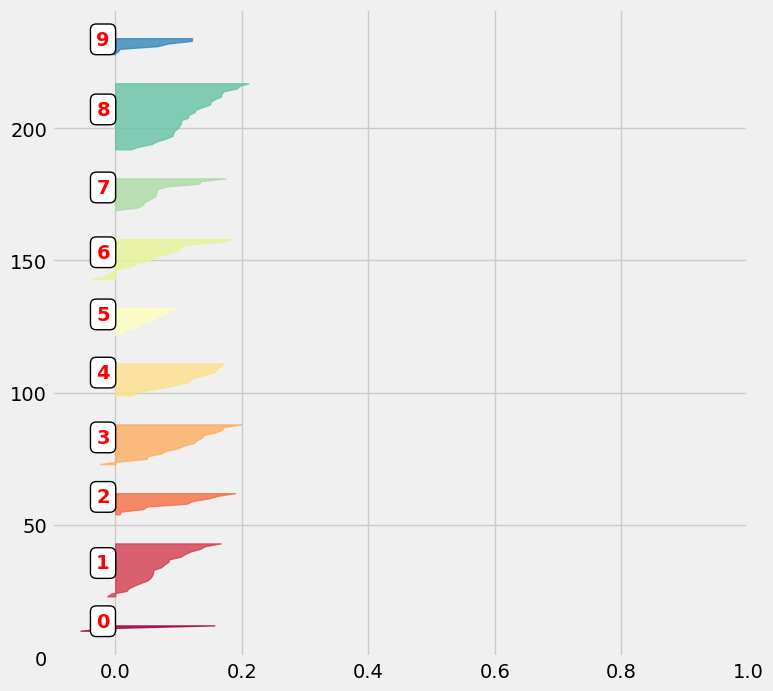

---


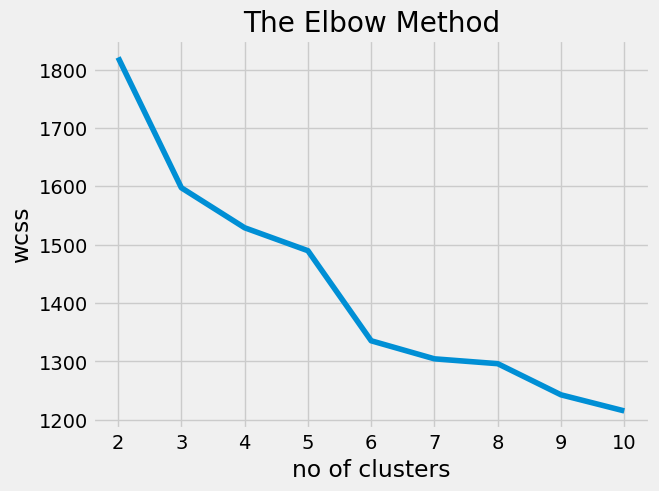

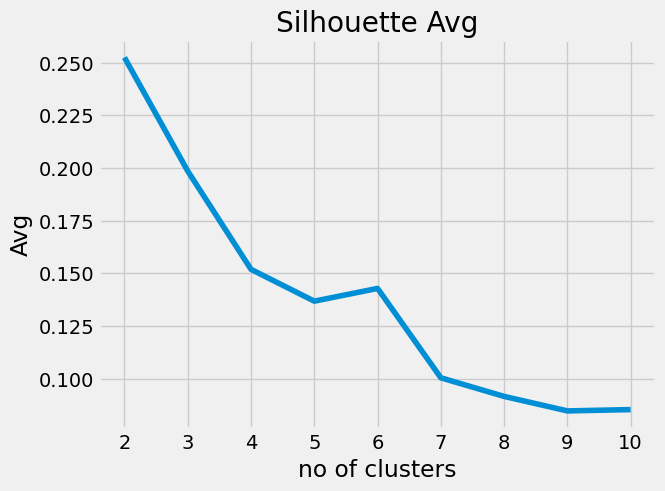

[1820.6810578661848, 1597.4804848653412, 1529.0105820105823, 1489.7355409596794, 1335.4629908103593, 1304.5421793076202, 1296.2451923076922, 1242.8888611388606, 1215.3680278055276]
[0.252428474600976, 0.1984958421753675, 0.15187688022320947, 0.13677995800819812, 0.14283078321286619, 0.10041023177108328, 0.09158224894385635, 0.08469942406253421, 0.08532003701748044]


In [256]:
benchmark_K_means(data, 11, True)

In [257]:
data.describe()

,Age,Gender,Occupation,Location,Shopping Frequency,"Online, instore preferences",Brand Preference,Likeliness of Promotion or Discount,Average Spent,Types of Clothing_Casual Wear,...,Preferred Types of Promotions or Discounts_Loyalty rewards programs,Communication Methods_SMS/text messages,Communication Methods_Social media updates,Communication Methods_In store notifications,Communication Methods_Leaflets,Communication Methods_Email newsletters,Payment Methods_Cash,Payment Methods_Credit/Debit Card,Payment Methods_Mobile Payment Apps,Payment Methods_Online Payment Platforms
count,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,...,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.00000
mean,0.540741,0.466667,2.777778,3.340741,2.059259,2.066667,0.325926,4.325926,1.918519,0.933333,...,0.266667,0.807407,0.918519,0.577778,0.229630,0.474074,0.733333,0.755556,0.103704,0.20000
std,0.895786,0.500746,1.619225,2.419334,0.789511,1.166702,0.470465,0.699996,0.930831,0.250373,...,0.443864,0.395804,0.274592,0.495753,0.422161,0.501187,0.443864,0.431358,0.306011,0.40149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,1.500000,1.000000,2.000000,1.000000,0.000000,4.000000,2.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,0.000000,0.000000,4.000000,4.000000,2.000000,3.000000,0.000000,4.000000,2.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
75%,1.000000,1.000000,4.000000,6.000000,3.000000,3.000000,1.000000,5.000000,2.500000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000
max,3.000000,1.000000,4.000000,6.000000,3.000000,3.000000,1.000000,5.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [258]:
data.groupby(["Age"]).count()

,Gender,Occupation,Location,Shopping Frequency,"Online, instore preferences",Brand Preference,Likeliness of Promotion or Discount,Average Spent,Types of Clothing_Casual Wear,Types of Clothing_Accessories,...,Preferred Types of Promotions or Discounts_Loyalty rewards programs,Communication Methods_SMS/text messages,Communication Methods_Social media updates,Communication Methods_In store notifications,Communication Methods_Leaflets,Communication Methods_Email newsletters,Payment Methods_Cash,Payment Methods_Credit/Debit Card,Payment Methods_Mobile Payment Apps,Payment Methods_Online Payment Platforms
Age,,,,,,,,,,,,,,,,,,,,,
0,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
1,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
2,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
3,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


# Section 4: Customer Segmentaion using K Means (With Dimention Reduction)

In [259]:
# data2 = data.drop(['Cluster', 'cluster'], axis=1)

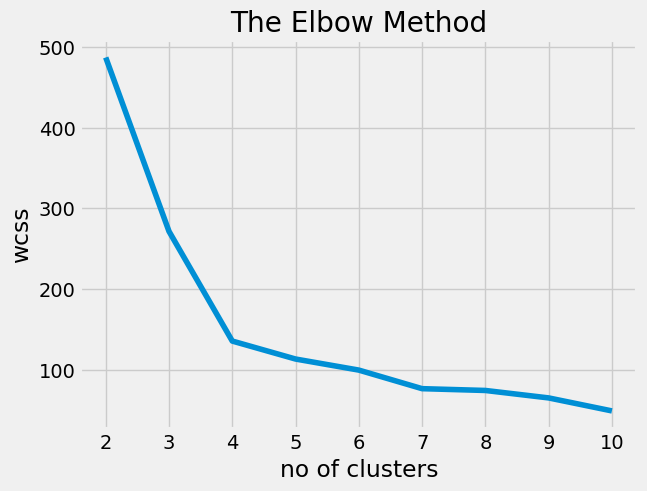

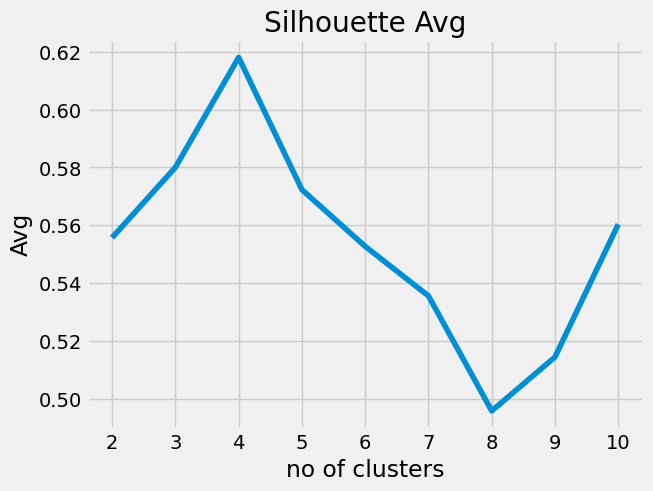

[486.75385787050465, 271.5398762566357, 135.74685618494635, 113.50638457188924, 99.80455197456382, 76.81643503223279, 74.59808974913187, 65.37274971419427, 49.289736243436224]
[0.5557475745441676, 0.5800302883898325, 0.6179935900342642, 0.5723253783002211, 0.552736180337353, 0.5356305132625995, 0.49591091401111204, 0.5145346906734811, 0.5603799615051028]


In [260]:
# Write this first
# PCA

# reduced data using PCA to 2 dims

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)


# then benchmarked the results
# First graph uses the elbow method analysis, it's plotted n_clusters = 2 to 10.
# wcss is withing cluster sum of squares
# by looking at the elbow method (ref: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans) and silttouse average scores we can determine the n_clusters = 4 is best for this
benchmark_K_means(reduced_data, 11)

In [261]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=4, n_init="auto")
data_copy = data.copy()
kmeans.fit(reduced_data)
data_copy['cluster'] = kmeans.labels_

In [262]:
data_copy['cluster'].describe()

count    135.000000
mean       1.155556
std        1.078049
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: cluster, dtype: float64

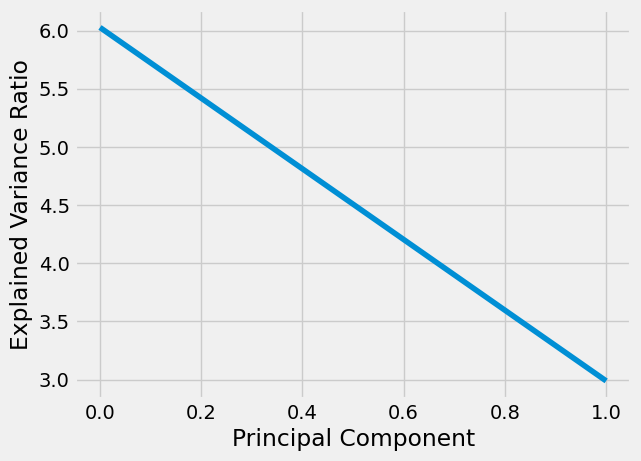

In [263]:
plt.plot(np.arange(len(pca.explained_variance_)), pca.explained_variance_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [264]:
def graph_comp(matrix, clusters, n_clusters):
  sample_silhouette_values = silhouette_samples(matrix, clusters)
  graph_component_silhouette(n_clusters, [-0.1, 1], len(matrix), sample_silhouette_values, clusters)

In [265]:
def k_means_plot(n):
  print("________________________________________________________")
  print(f"Each of this indicate the silhouette analysis when the n_clusters = {n}.")
  print(f"Number of Clusters = {n}" )
  kmeans = KMeans(init="k-means++", n_clusters=n, n_init='auto', )
  C = kmeans.fit_predict(reduced_data)
  silhouette_avg = silhouette_score(reduced_data, C)
  print(f"score: {silhouette_avg}")

  graph_comp(reduced_data, C, n)
  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
  y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(1)
  plt.clf()
  plt.imshow(
      Z,
      interpolation="nearest",
      extent=(xx.min(), xx.max(), yy.min(), yy.max()),
      cmap=plt.cm.Paired,
      aspect="auto",
      origin="lower",
  )

  plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_
  plt.scatter(
      centroids[:, 0],
      centroids[:, 1],
      marker="x",
      s=169,
      linewidths=3,
      color="w",
      zorder=10,
  )
  plt.title(str(n) + " clusters")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()
  print("________________________________________________________")

In [266]:
def cluster_area_plot(data, model, n, h = 0.02):
  x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
  y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(1)
  plt.clf()
  plt.imshow(
      Z,
      interpolation="nearest",
      extent=(xx.min(), xx.max(), yy.min(), yy.max()),
      cmap=plt.cm.Paired,
      aspect="auto",
      origin="lower",
  )

  plt.plot(data[:, 0], data[:, 1], "k.", markersize=2)
  # Plot the centroids
  centroids = model.cluster_centers_
  plt.scatter(
      centroids[:, 0],
      centroids[:, 1],
      marker="o",
      s=169,
      linewidths=3,
      color="w",
      zorder=10,
  )
  plt.title(str(n) + " clusters")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 2.
Number of Clusters = 2
score: 0.5557475745441676


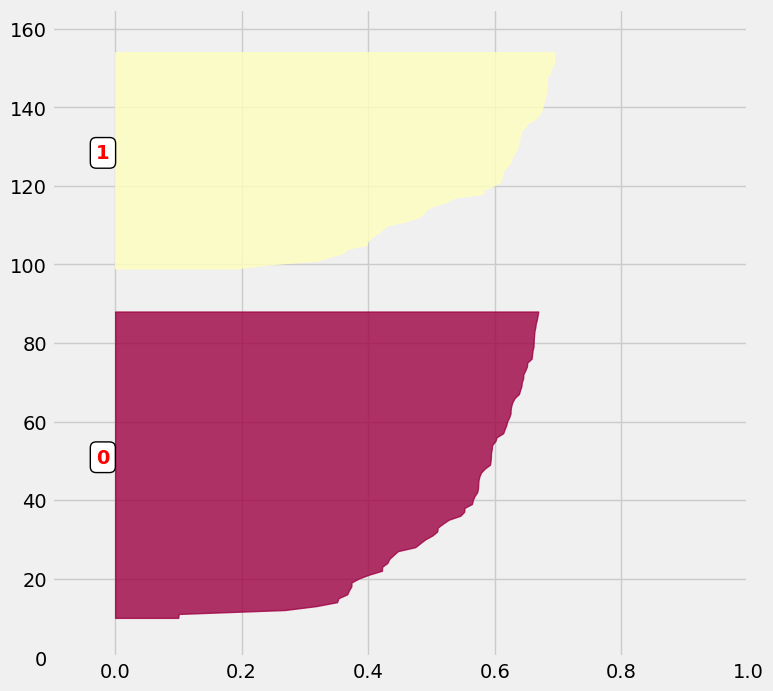

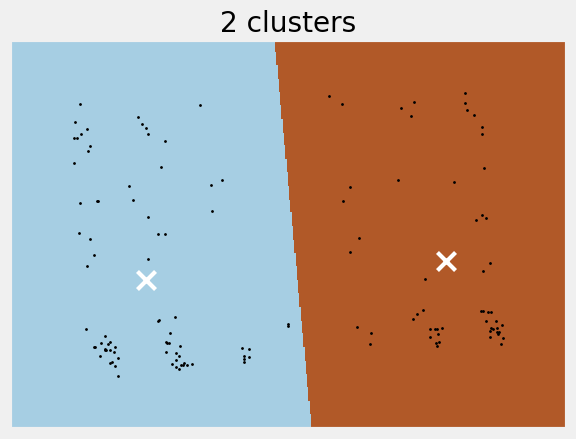

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 3.
Number of Clusters = 3
score: 0.5800302883898325


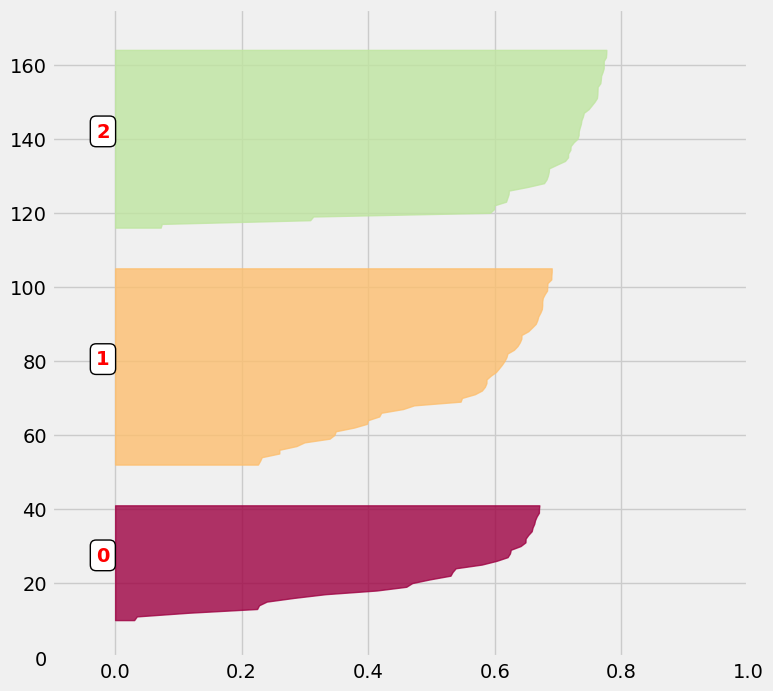

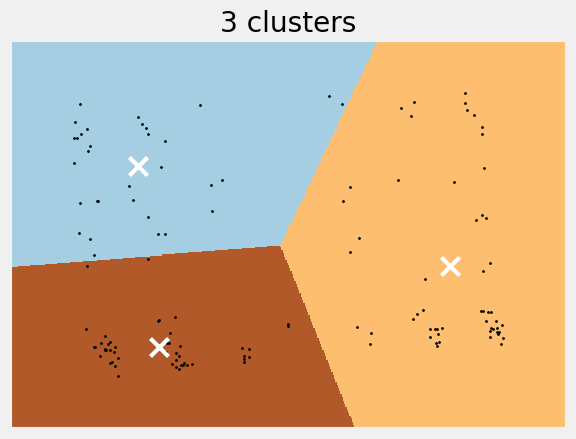

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 4.
Number of Clusters = 4
score: 0.6204244444241435


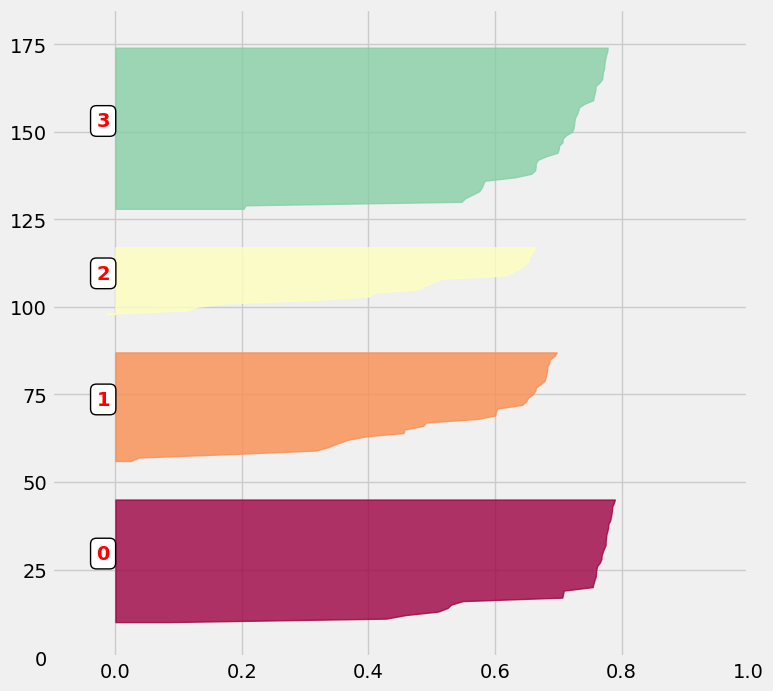

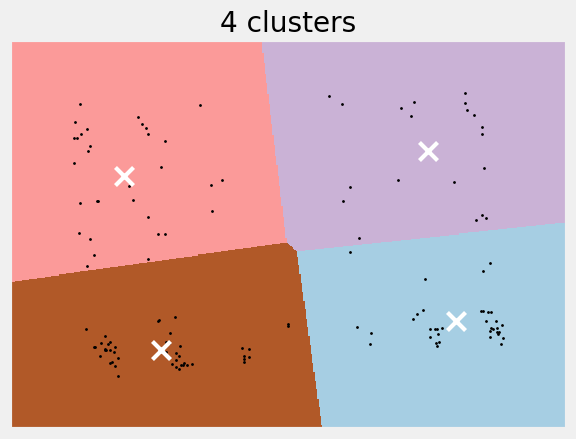

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 5.
Number of Clusters = 5
score: 0.5723253783002211


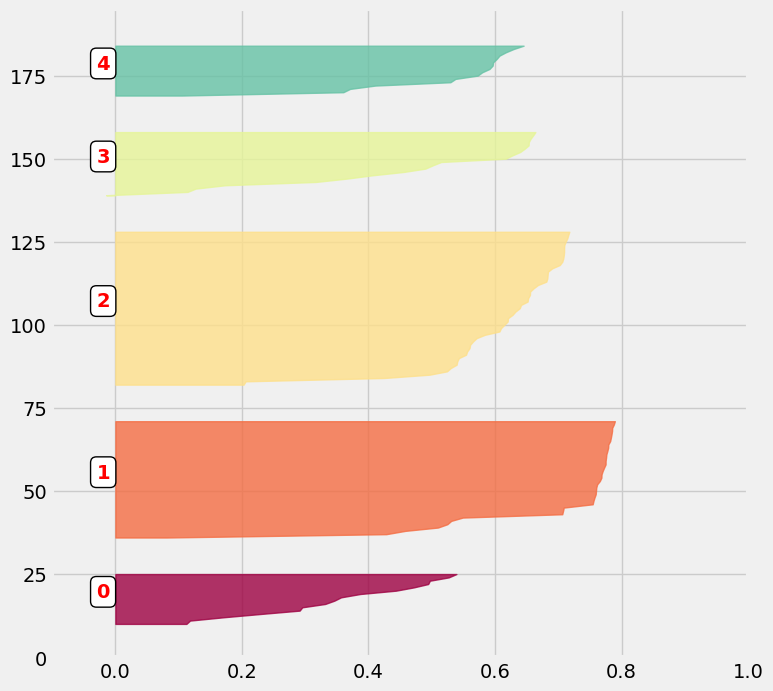

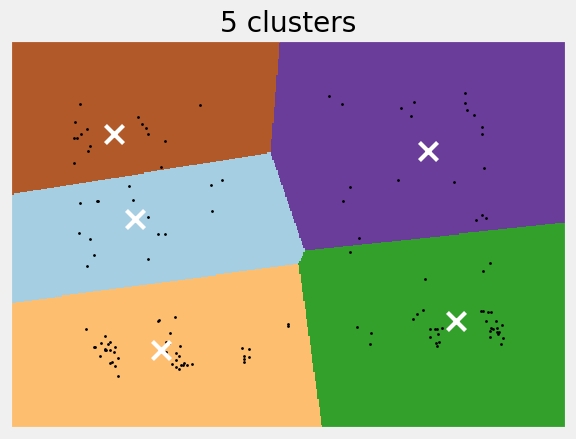

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 6.
Number of Clusters = 6
score: 0.5577715414503502


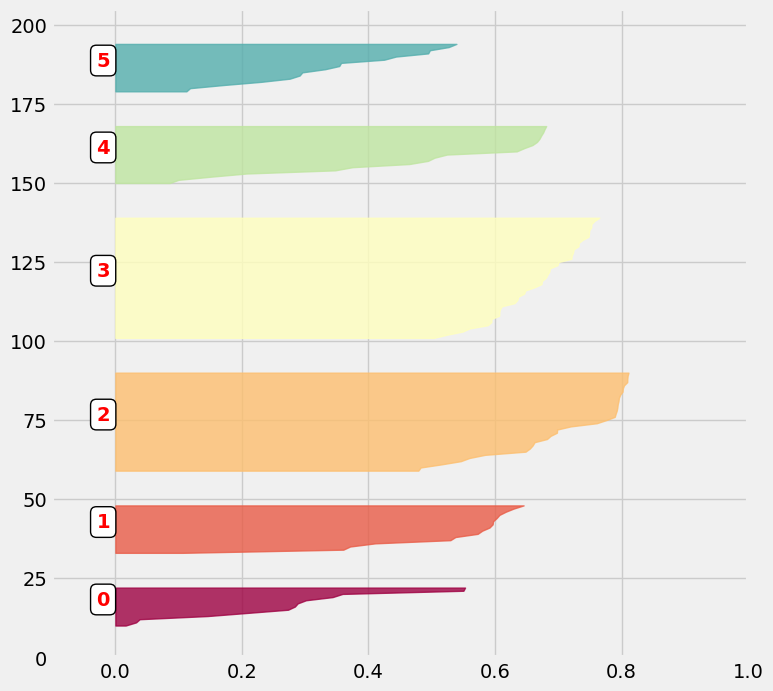

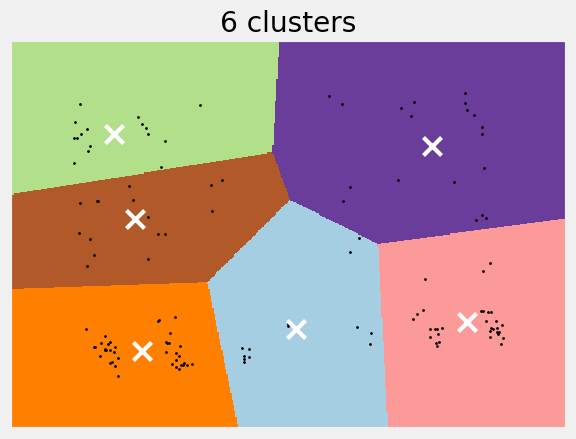

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 7.
Number of Clusters = 7
score: 0.539497216318887


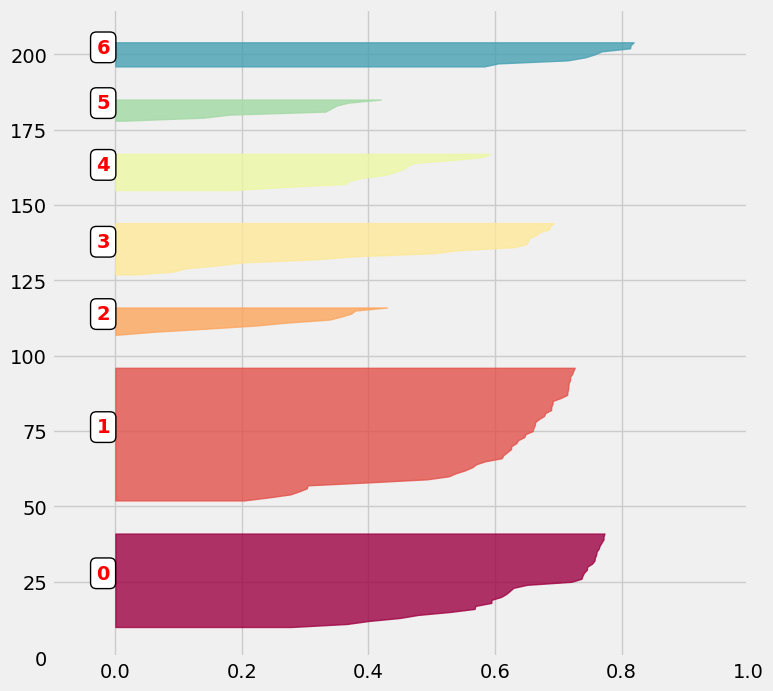

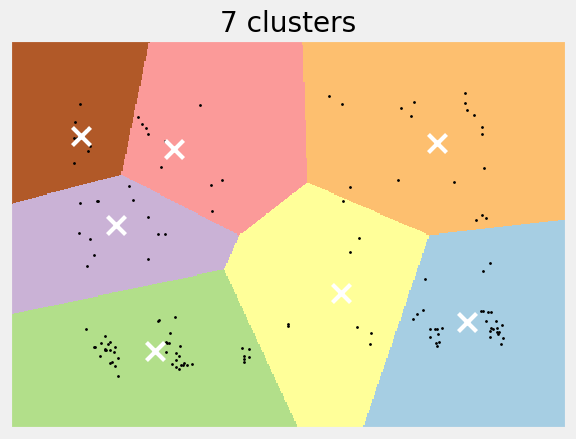

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 8.
Number of Clusters = 8
score: 0.5522832268962763


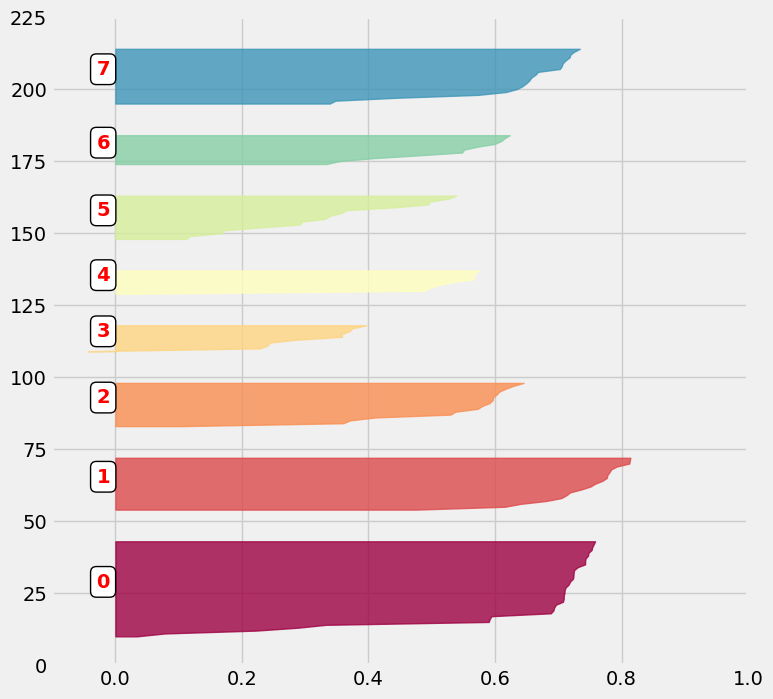

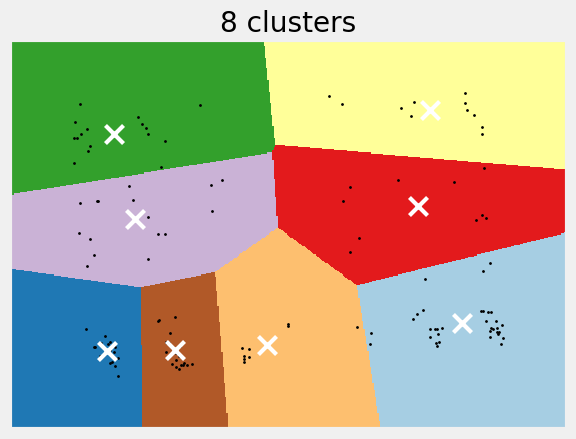

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 9.
Number of Clusters = 9
score: 0.5429346576063888


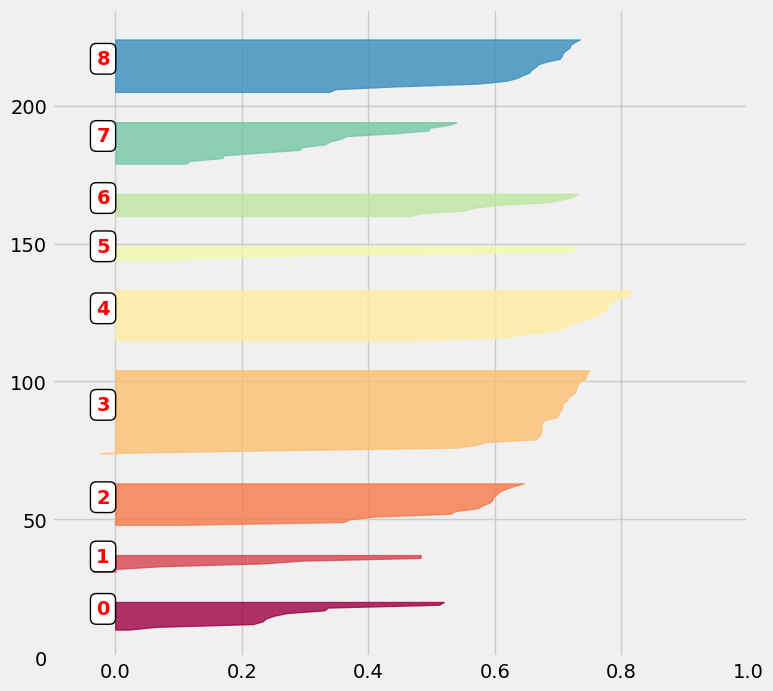

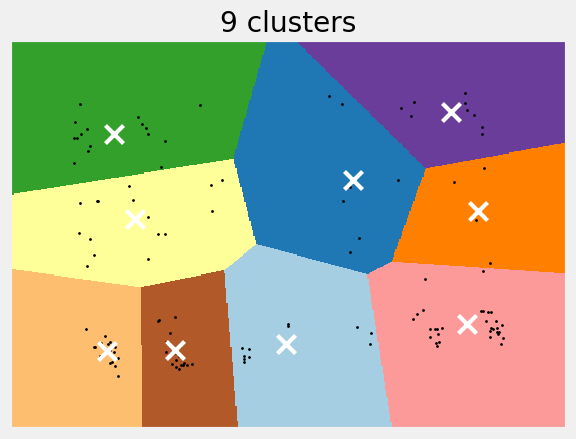

________________________________________________________
________________________________________________________
Each of this indicate the silhouette analysis when the n_clusters = 10.
Number of Clusters = 10
score: 0.5488563938782338


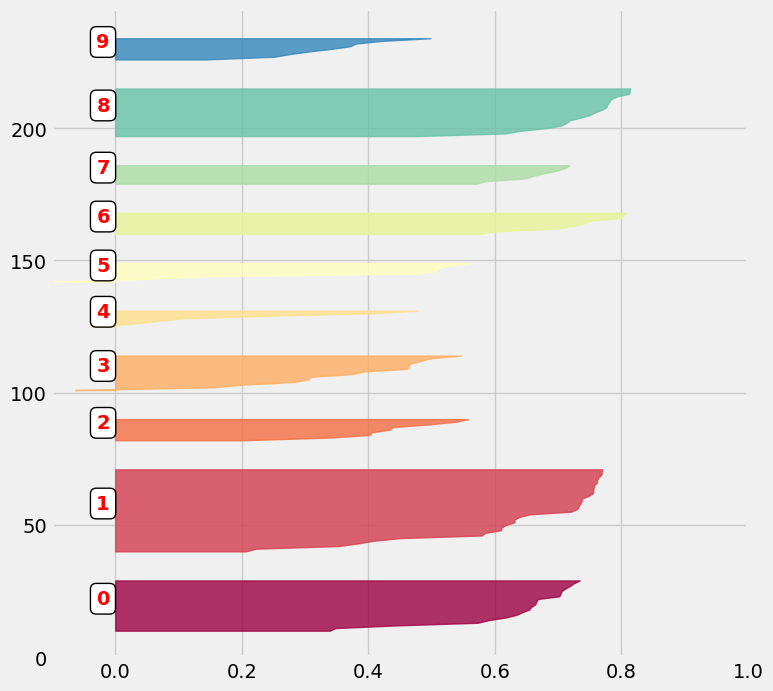

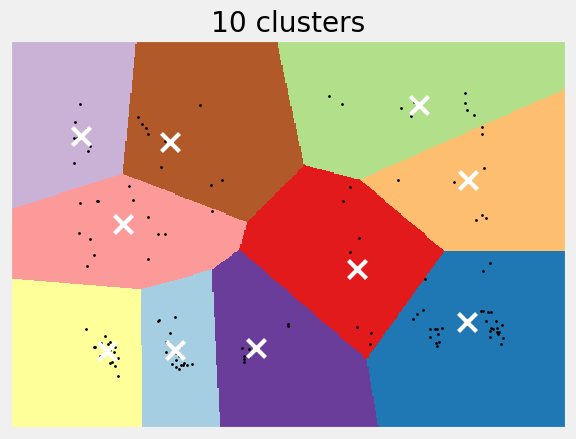

________________________________________________________


In [267]:
for n in range(2, 11):
  k_means_plot(n)

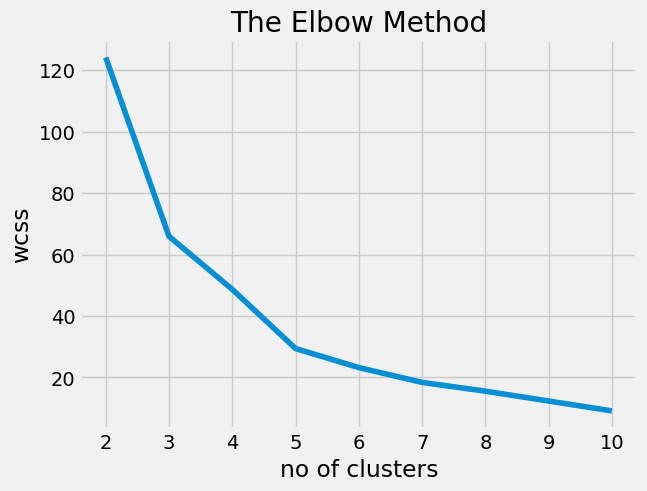

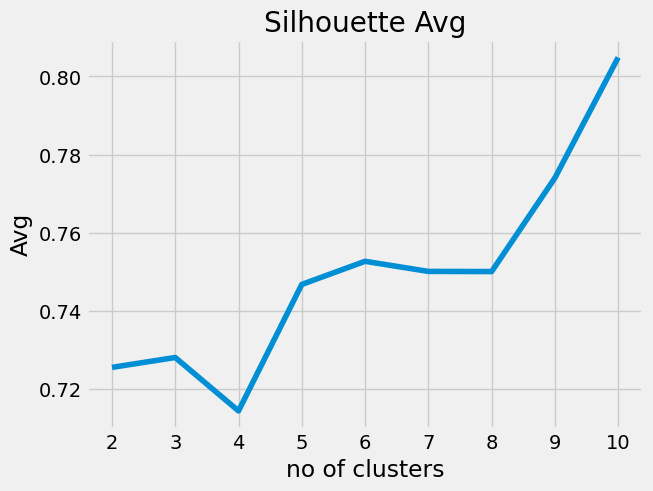

[124.16916465774887, 65.94312992514986, 48.68422431109462, 29.425798555336492, 23.227278542248285, 18.39840713082546, 15.5473177247449, 12.336212847333815, 9.120352953010947]
[0.7254284749050771, 0.7279638174468801, 0.7142693104152987, 0.7466943047681879, 0.7526258265642832, 0.7500270798764918, 0.7499938885188129, 0.7739921508441261, 0.8048781891408688]


In [268]:
# Section 5: Demographic Customer Segmentaion using K Means (With Dimention Reduction)

reduced_demographic_data = PCA(n_components=2).fit_transform(data[['Age', 'Gender', 'Occupation']])

benchmark_K_means(reduced_demographic_data, 11)

# Demographic Segmentation (Without PCA)

     Gender  Occupation  Location  Shopping Frequency
Age                                                  
0        89          89        89                  89
1        29          29        29                  29
2         7           7         7                   7
3        10          10        10                  10


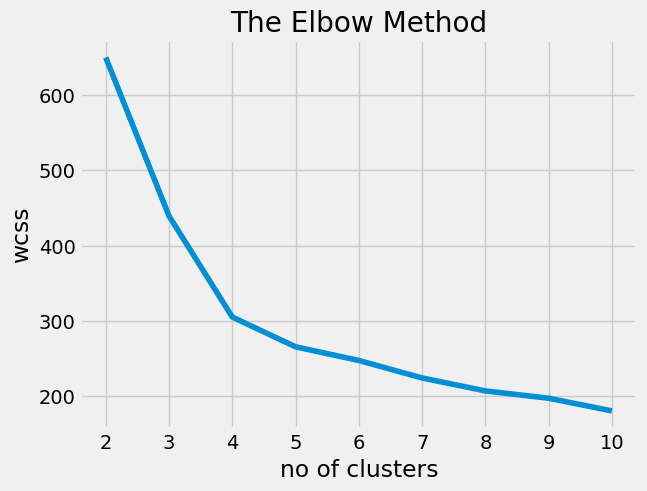

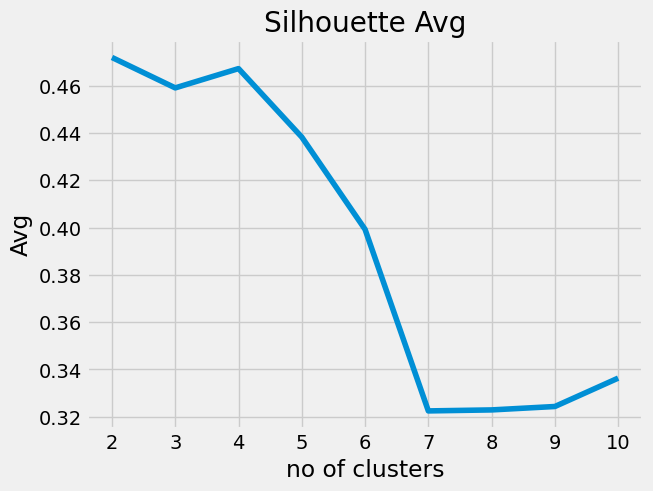

[649.7323688969257, 439.2407479045777, 305.05930851063835, 265.45315771698745, 247.33252279635258, 224.09644225506293, 206.90001368363437, 197.18113354037274, 180.34383195307112]
[0.47202798712111377, 0.4591497756634266, 0.4673084750542521, 0.4383276967127352, 0.39927861465939557, 0.3224659241003073, 0.32288745686343523, 0.3243318446023855, 0.3363414479358866]


In [269]:
demographic_data = data[["Age", "Gender", "Occupation", "Location", "Shopping Frequency"]] # select the features that applicable for demographic segmentation

print(demographic_data.groupby(["Age"]).count())
benchmark_K_means(demographic_data, 11)

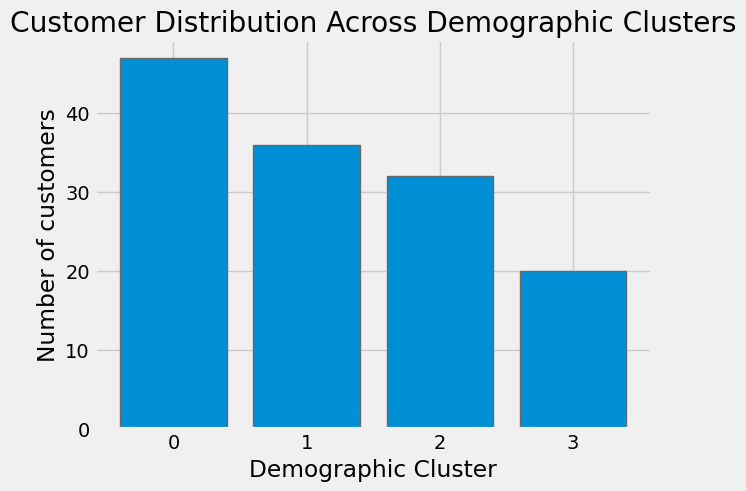

In [270]:
# By looking at the benchmark_K_means results n_clusters = 4 will be the optimum

# Perform customer segmentation using k-means clustering



demographic_best_n_clusters = 4

kmeans = KMeans(n_clusters=demographic_best_n_clusters, random_state=4, n_init="auto")  # Adjust the number of clusters based on your analysis
raw_data["Demographic Cluster"] = kmeans.fit_predict(demographic_data)

# Create visualizations to explore segmentation results

# 1. Distribution of customers across clusters
plt.bar([f"{i}" for i in range(demographic_best_n_clusters)], raw_data["Demographic Cluster"].value_counts())
plt.xlabel("Demographic Cluster")
plt.ylabel("Number of customers")
plt.title("Customer Distribution Across Demographic Clusters")
plt.show()


In [271]:
def draw_plot(n_clusters, xlabel, xlim=3):
  fig, ax = plt.subplots(2, 2, figsize=(8, 10))

  for c1 in range(int(n_clusters / 2)):
      for c2 in range(int(n_clusters / 2)):
        ax[c1, c2].set_xlim(right=xlim)
        ax[c1, c2].set_ylim(0, 45)
        ax[c1, c2].hist(raw_data.loc[raw_data["Demographic Cluster"] == (2 * c1) + c2, xlabel])
        ax[c1, c2].set_xlabel(xlabel,  fontsize='small')
        ax[c1, c2].set_ylabel("Number of customers",  fontsize='small')
        ax[c1, c2].set_title("Cluster {}".format((2 * c1) + c2),  fontsize='small')
  plt.show()

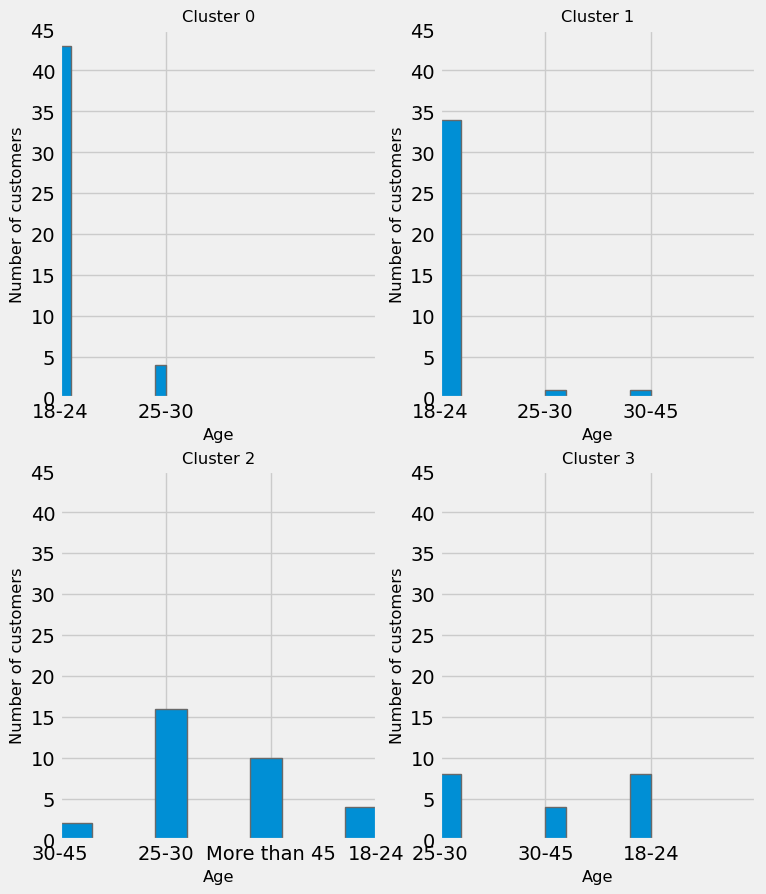

In [272]:
# 2. Age distribution within each cluster
draw_plot(4, "Age")

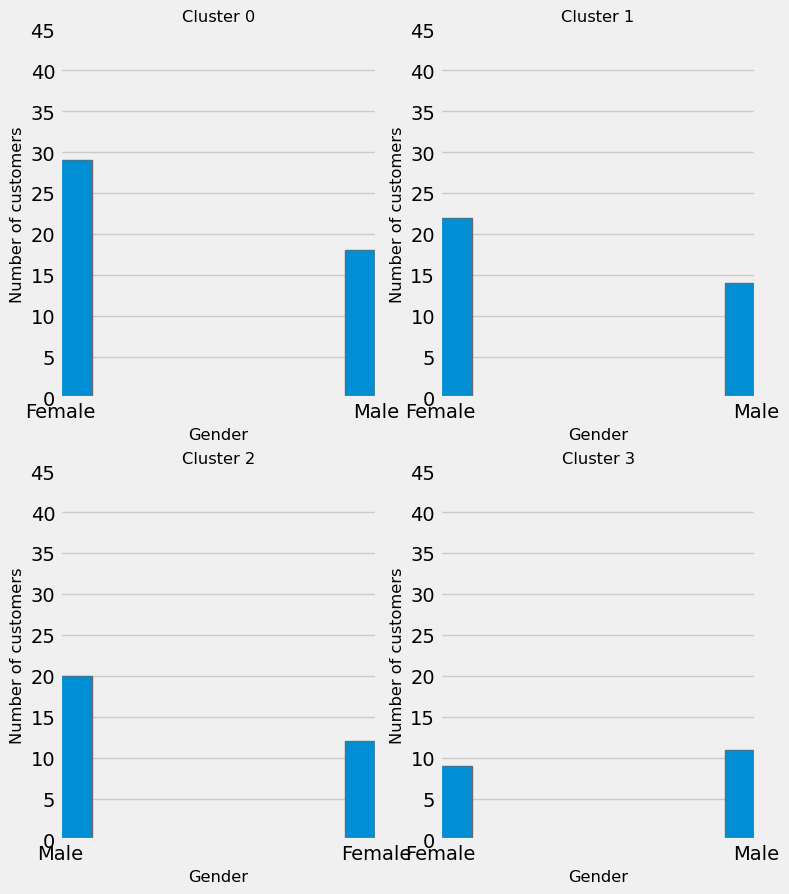

In [273]:
draw_plot(4, "Gender", 1)

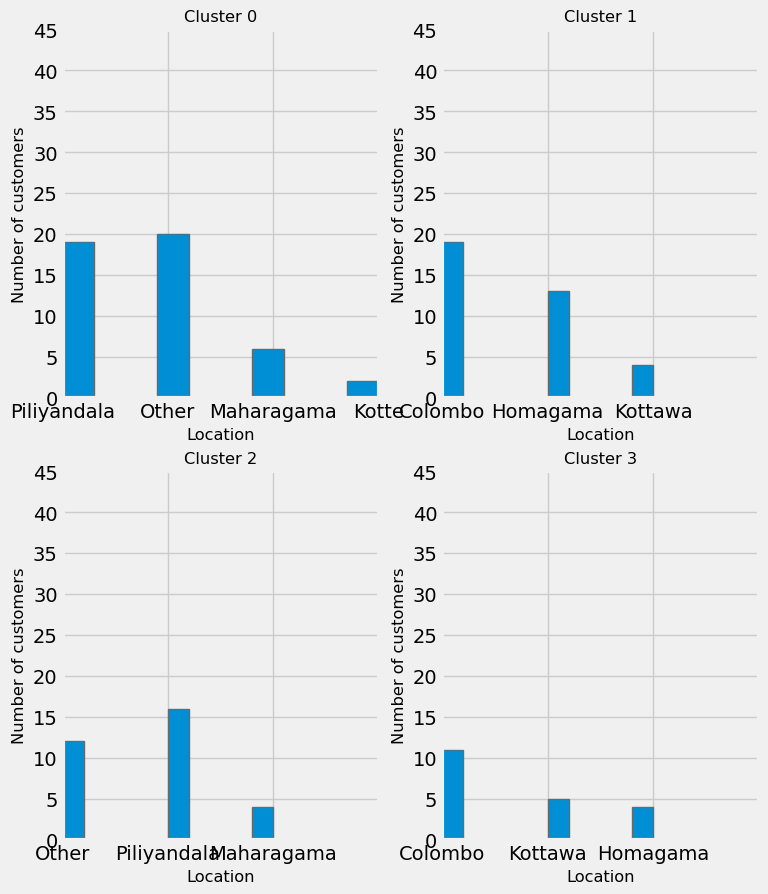

In [274]:
draw_plot(4, "Location")

# Demographic Segmentation (With PCA)

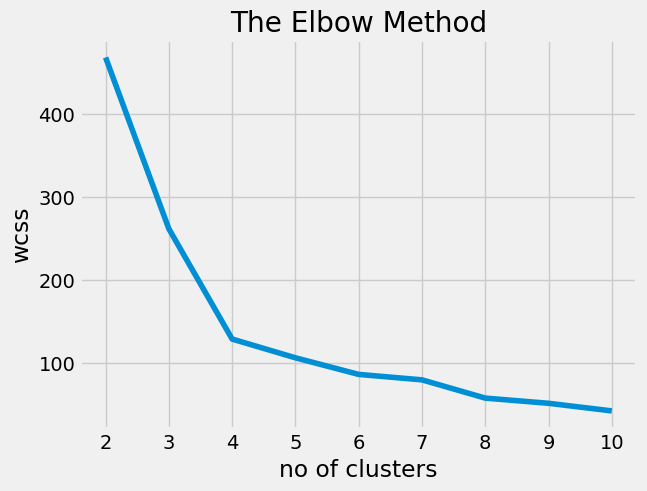

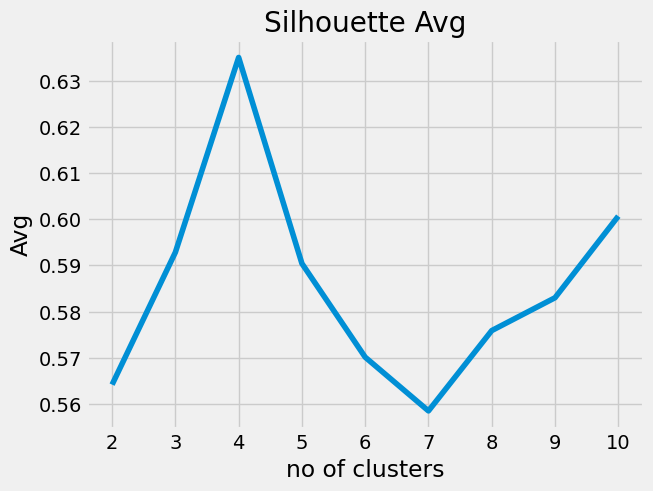

[468.4351389876342, 261.91607979533785, 129.08486099825623, 106.51318511218474, 86.49944696849695, 79.94664636826931, 57.953380631969345, 51.69767680392094, 42.51440290394625]
[0.564132201892019, 0.5928496942580759, 0.6351385754351683, 0.5904190359844967, 0.5700868664879206, 0.55842673400525, 0.575860587585473, 0.5829882277060991, 0.6006963531956364]


In [275]:
demographic_data = data[["Age", "Gender", "Occupation", "Location", "Shopping Frequency"]] # select the features that applicable for demographic segmentation

pca = PCA(n_components=2)
reduced_demographic_data = pca.fit_transform(demographic_data)

benchmark_K_means(reduced_demographic_data, 11)

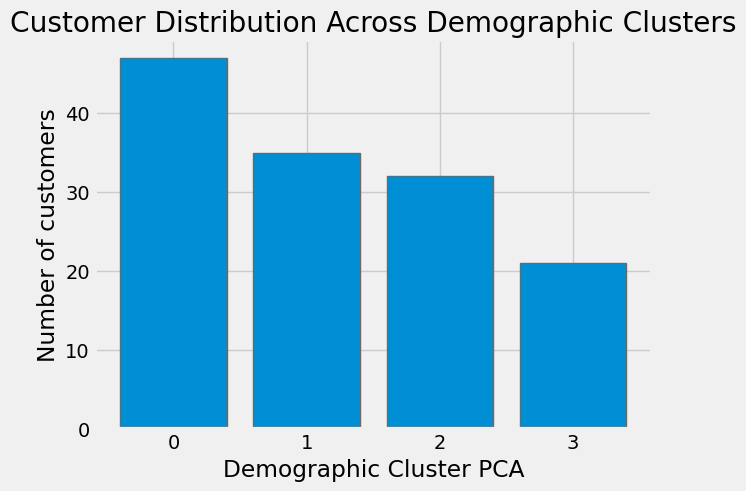

In [276]:
N_CLUSTERS = 4

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=4, n_init="auto")  # Adjust the number of clusters based on your analysis
demographic_data["Demographic Cluster PCA"] = kmeans.fit_predict(reduced_demographic_data)

# 1. Distribution of customers across clusters
plt.bar([f"{i}" for i in range(N_CLUSTERS)], demographic_data["Demographic Cluster PCA"].value_counts())
plt.xlabel("Demographic Cluster PCA")
plt.ylabel("Number of customers")
plt.title("Customer Distribution Across Demographic Clusters")
plt.show()

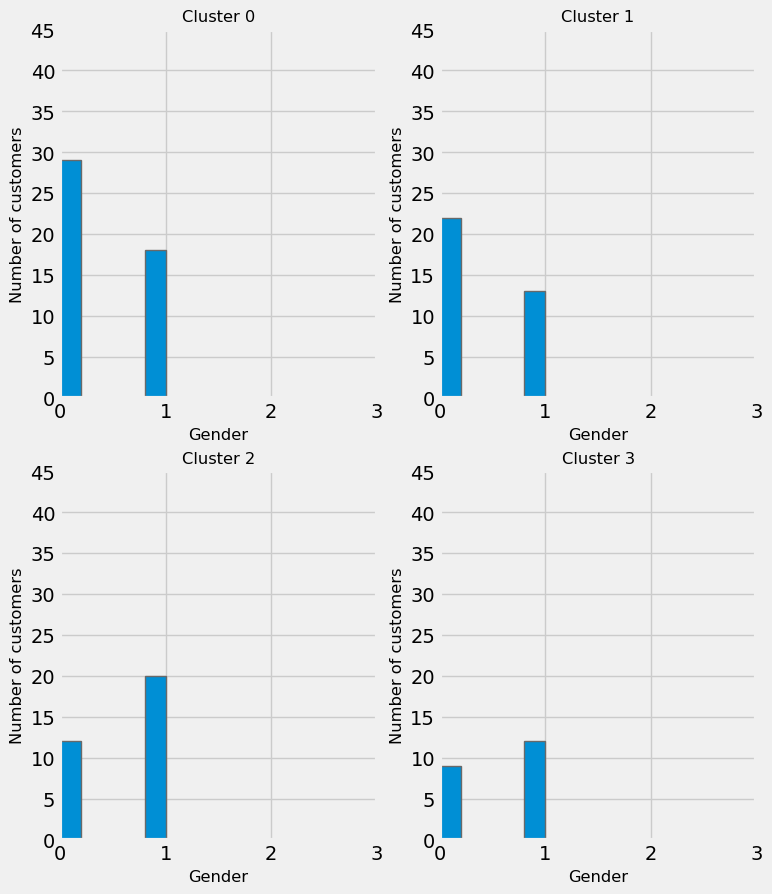

In [277]:
# 2. Age distribution within each cluster
fig, ax = plt.subplots(2, 2, figsize=(8, 10))

for c1 in range(int(demographic_best_n_clusters / 2)):
    for c2 in range(int(demographic_best_n_clusters / 2)):
      ax[c1, c2].set_xlim(right=3)
      ax[c1, c2].set_ylim(0, 45)
      ax[c1, c2].hist(demographic_data.loc[demographic_data["Demographic Cluster PCA"] == (2 * c1) + c2, "Gender"], range=(-1, 1))
      ax[c1, c2].set_xlabel("Gender",  fontsize='small')
      ax[c1, c2].set_ylabel("Number of customers",  fontsize='small')
      ax[c1, c2].set_title("Cluster {}".format((2 * c1) + c2),  fontsize='small')
plt.show()

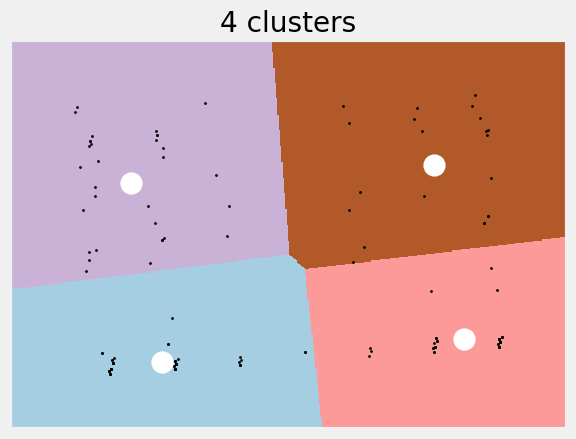

In [278]:
cluster_area_plot(reduced_demographic_data, kmeans, N_CLUSTERS)

In [279]:
data

,Age,Gender,Occupation,Location,Shopping Frequency,"Online, instore preferences",Brand Preference,Likeliness of Promotion or Discount,Average Spent,Types of Clothing_Casual Wear,...,Preferred Types of Promotions or Discounts_Loyalty rewards programs,Communication Methods_SMS/text messages,Communication Methods_Social media updates,Communication Methods_In store notifications,Communication Methods_Leaflets,Communication Methods_Email newsletters,Payment Methods_Cash,Payment Methods_Credit/Debit Card,Payment Methods_Mobile Payment Apps,Payment Methods_Online Payment Platforms
0,0,0,4,0,3,3,0,3,0,1,...,0,1,1,1,0,0,1,0,0,0
1,0,0,4,0,2,0,1,3,2,1,...,0,0,1,1,1,0,0,1,0,0
2,0,0,4,6,2,0,0,5,2,1,...,0,1,1,0,0,1,1,0,0,0
3,0,0,4,6,3,1,0,4,0,1,...,0,1,1,1,0,0,1,1,0,0
4,1,0,2,0,1,0,0,5,3,1,...,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0,0,4,0,2,3,1,5,2,1,...,1,1,1,0,0,1,0,1,0,0
131,0,0,4,6,1,1,0,5,2,1,...,0,1,1,1,0,0,1,0,0,0
132,0,0,4,4,2,3,0,4,2,1,...,0,1,1,1,0,0,1,1,1,1
133,0,1,0,5,1,0,0,4,0,1,...,0,1,1,0,1,0,1,1,0,0


In [280]:
# Brand Choice Factors
# Influence Factors
# Shopping Frequency
# Shopping Methods
# Online, In-store Preferences
# Types of Clothing
# Average Spent
# Prefered Types of Promotions or Discounts
# Likeliness of Promotion or Discount

psychographic_data = data[['Online, instore preferences', 'Shopping Frequency', 'Brand Preference',
       'Likeliness of Promotion or Discount', 'Average Spent',
       'Types of Clothing_Casual Wear',
       'Types of Clothing_Accessories',
       'Types of Clothing_Formal Wear',
       'Types of Clothing_Athletic/Activewear',
       'Types of Clothing_Ethnic or traditional wear',
       'Shopping Methods_Physical retail stores',
       'Shopping Methods_Online fashion stores/ web-sites',
       'Shopping Methods_Department stores', 'Shopping Methods_Boutiques',
       'Shopping Methods_Thrift/ Second Hand shops',
       'Influence Factors_Availability of a wide range of options',
       'Influence Factors_Competitive pricing',
       'Influence Factors_Ability to try on products before purchasing',
       'Influence Factors_Convenience',
       'Influence Factors_Personalized shopping experience',
       'Influence Factors_Environmental considerations (eg. reduce carbon emission)',
       'Brand Choice Factors_Price and affordability',
       'Brand Choice Factors_Trendiness and style',
       'Brand Choice Factors_Promotions and Discounts',
       'Brand Choice Factors_Brand reputation and quality',
       'Brand Choice Factors_Brand\'s commitment to sustainability',
       'Preferred Types of Promotions or Discounts_Percentage discounts',
       'Preferred Types of Promotions or Discounts_Seasonal sales',
       'Preferred Types of Promotions or Discounts_Other',
       'Preferred Types of Promotions or Discounts_Buy-one-get-one(BOGO) deals',
       'Preferred Types of Promotions or Discounts_Free shipping',
       'Preferred Types of Promotions or Discounts_Loyalty rewards programs']]

print(len(psychographic_data.columns))
psychographic_data.columns

32


Index(['Online, instore preferences', 'Shopping Frequency', 'Brand Preference',
       'Likeliness of Promotion or Discount', 'Average Spent',
       'Types of Clothing_Casual Wear', 'Types of Clothing_Accessories',
       'Types of Clothing_Formal Wear',
       'Types of Clothing_Athletic/Activewear',
       'Types of Clothing_Ethnic or traditional wear',
       'Shopping Methods_Physical retail stores',
       'Shopping Methods_Online fashion stores/ web-sites',
       'Shopping Methods_Department stores', 'Shopping Methods_Boutiques',
       'Shopping Methods_Thrift/ Second Hand shops',
       'Influence Factors_Availability of a wide range of options',
       'Influence Factors_Competitive pricing',
       'Influence Factors_Ability to try on products before purchasing',
       'Influence Factors_Convenience',
       'Influence Factors_Personalized shopping experience',
       'Influence Factors_Environmental considerations (eg. reduce carbon emission)',
       'Brand Choice Factor

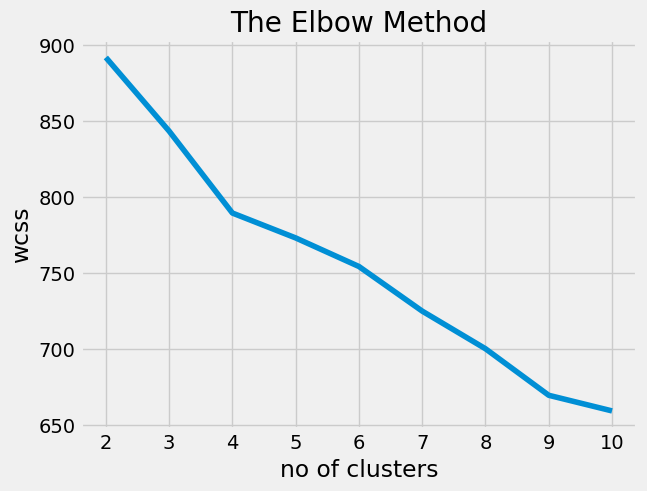

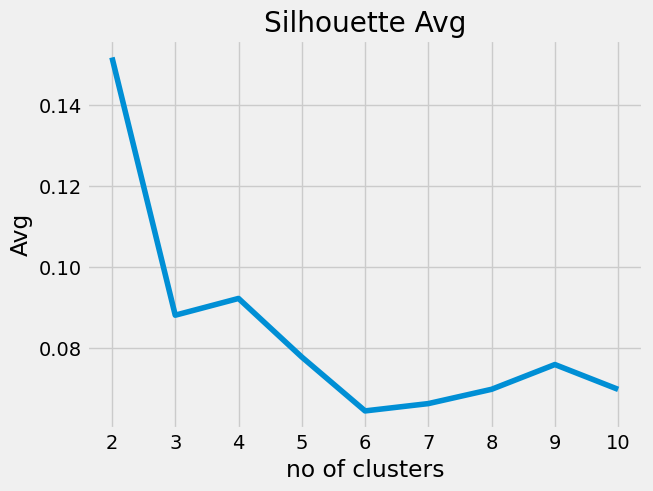

[891.7482352941175, 843.2490006447454, 789.2821877309682, 772.892491900483, 754.0761183064974, 724.6986549654187, 699.9067897554603, 669.2567432567432, 658.9703102453102]
[0.1517967842878331, 0.0881731399257142, 0.09230793222678298, 0.07784920057248976, 0.0645477351867617, 0.06635471070571762, 0.06988658338229328, 0.07599440131245774, 0.06986257328144643]


In [281]:
benchmark_K_means(psychographic_data, 11)

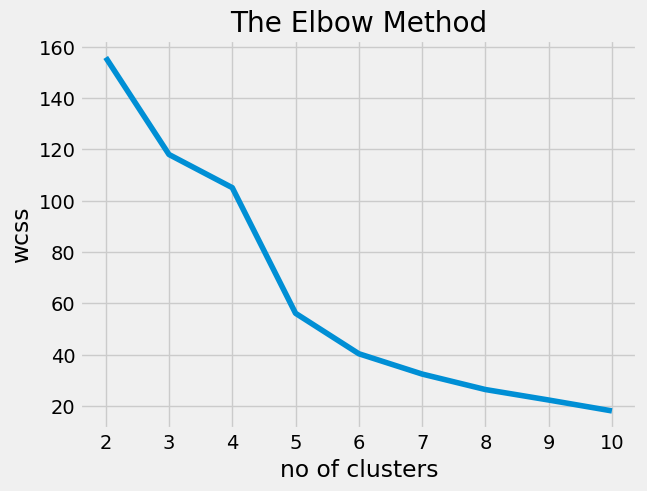

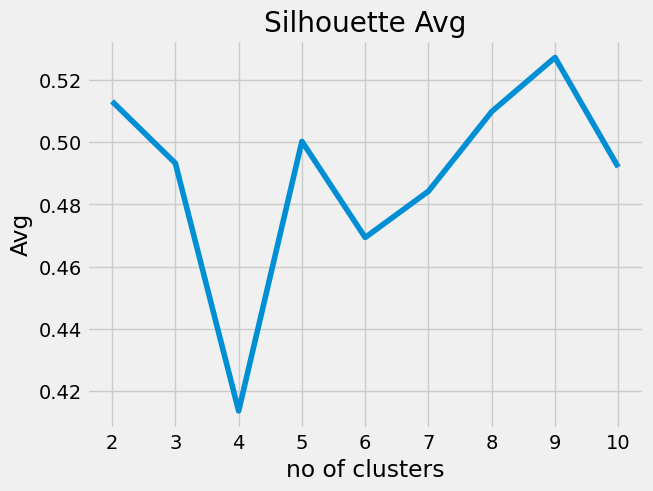

[155.85877816344936, 118.01289806263132, 105.07624943487906, 56.09266058007243, 40.31629777537758, 32.39875390251608, 26.35767109227516, 22.268736323759402, 18.019727971126912]
[0.5131647863918218, 0.49325293676275345, 0.41362597682188795, 0.5002898797163539, 0.46938425057345456, 0.48426557077082033, 0.5098737705809259, 0.5272687393011732, 0.49199067072474034]


In [282]:
# psychographic_data.columns
pca = PCA(n_components=2)
reduced_psychographic_data = pca.fit_transform(psychographic_data)

benchmark_K_means(reduced_psychographic_data, 11)

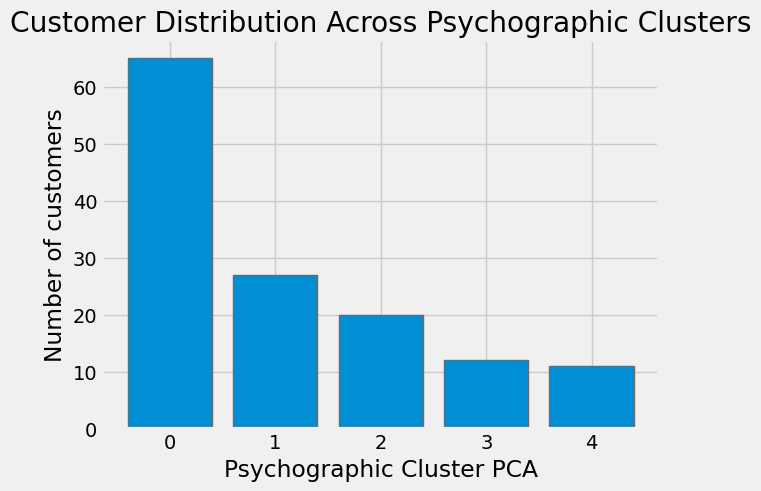

In [283]:
N_CLUSTERS = 5

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=4, n_init="auto")  # Adjust the number of clusters based on your analysis
psychographic_data["Psychographic Cluster PCA"] = kmeans.fit_predict(reduced_psychographic_data)

# 1. Distribution of customers across clusters
plt.bar([f"{i}" for i in range(N_CLUSTERS)], psychographic_data["Psychographic Cluster PCA"].value_counts())
plt.xlabel("Psychographic Cluster PCA")
plt.ylabel("Number of customers")
plt.title("Customer Distribution Across Psychographic Clusters")
plt.show()

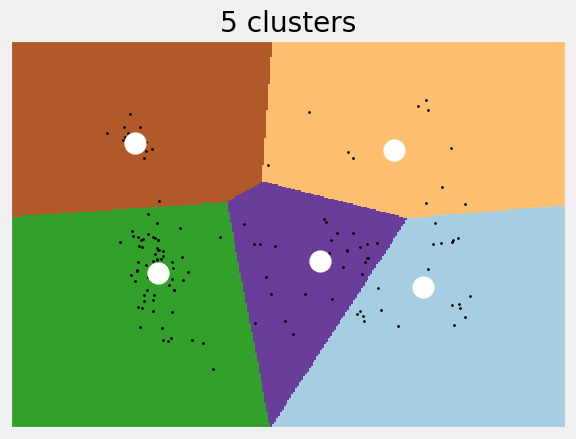

In [284]:
cluster_area_plot(reduced_psychographic_data, kmeans, N_CLUSTERS)

In [285]:
# Online, In-store Preferences
# Communication Method
# Payment Methods

technographic_data = data[['Payment Methods_Cash', 'Payment Methods_Credit/Debit Card',
       'Payment Methods_Mobile Payment Apps',
       'Payment Methods_Online Payment Platforms', 'Communication Methods_SMS/text messages',
       'Communication Methods_Social media updates',
       'Communication Methods_In store notifications',
       'Communication Methods_Leaflets',
       'Communication Methods_Email newsletters', 'Online, instore preferences']]

len(technographic_data.columns)

10

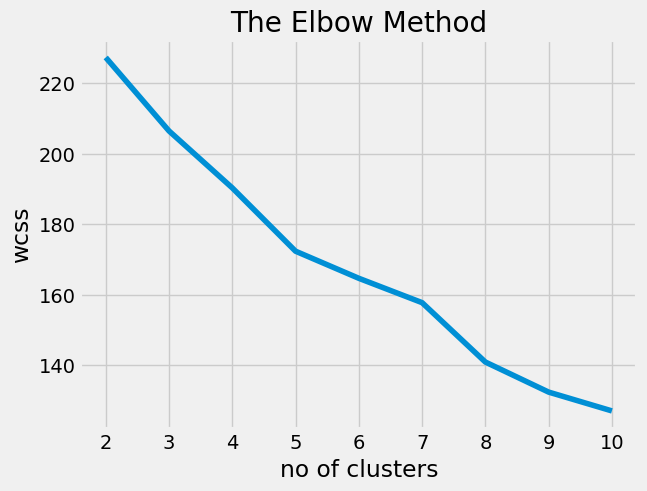

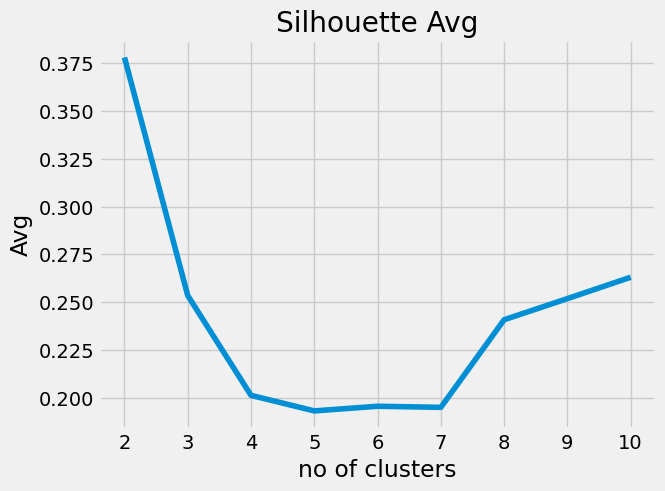

[227.3266441005803, 206.4617744011, 190.2931199616889, 172.31654135338346, 164.61888053467004, 157.70382395382398, 140.84220979361646, 132.30644845350727, 126.96517861223742]
[0.37812133172306517, 0.25345480512554674, 0.20120680006247382, 0.19306835770585573, 0.19550722250213196, 0.194932322290675, 0.24080101805037857, 0.2518624077864459, 0.2630503833475786]


In [286]:
benchmark_K_means(technographic_data, 11)

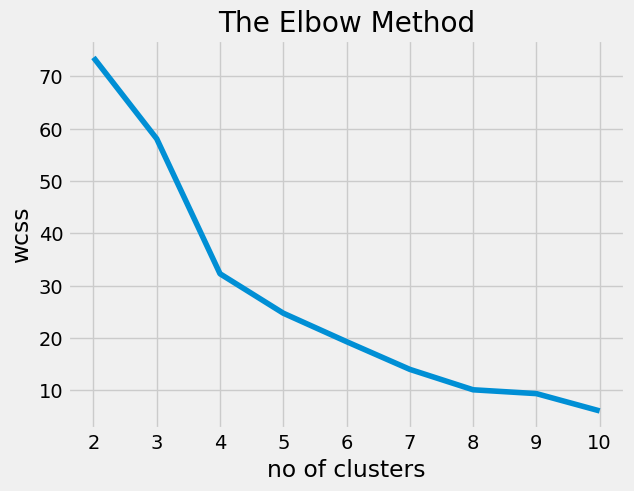

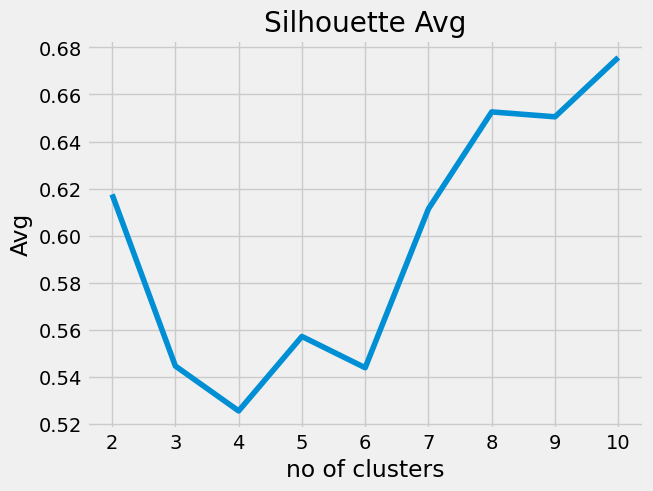

[73.63053890892822, 58.0691185445006, 32.2551553496348, 24.71405402123824, 19.26771991630024, 13.966705805432332, 10.062902239613717, 9.332175507729056, 6.022673322372752]
[0.6175086530094285, 0.544524854255595, 0.5254303551801079, 0.5570950410897341, 0.5437916924268065, 0.6113799928436787, 0.6525968509450477, 0.6505165715733205, 0.6757538976189232]


In [287]:
pca = PCA(n_components=2)
reduced_technographic_data = pca.fit_transform(technographic_data)

benchmark_K_means(reduced_technographic_data, 11)

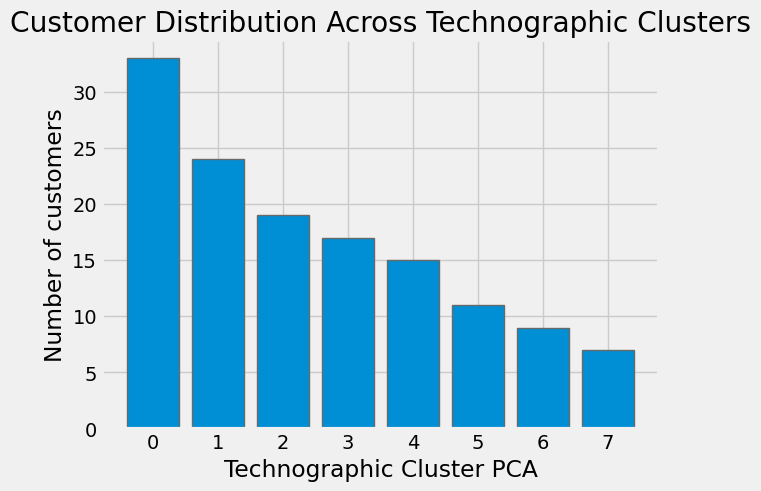

In [288]:
N_CLUSTERS = 8

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=4, n_init="auto")  # Adjust the number of clusters based on your analysis
technographic_data["Technographic Cluster PCA"] = kmeans.fit_predict(reduced_technographic_data)

# 1. Distribution of customers across clusters
plt.bar([f"{i}" for i in range(N_CLUSTERS)], technographic_data["Technographic Cluster PCA"].value_counts())
plt.xlabel("Technographic Cluster PCA")
plt.ylabel("Number of customers")
plt.title("Customer Distribution Across Technographic Clusters")
plt.show()

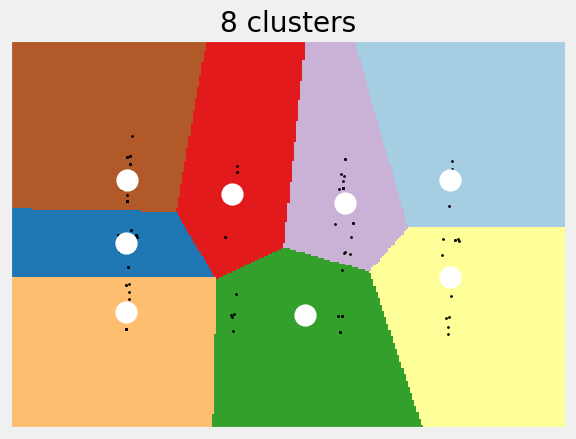

In [289]:
cluster_area_plot(reduced_technographic_data, kmeans, N_CLUSTERS)

In [290]:
# Shopping Frequency
# Shopping Methods
# Online, In-store Preferences
# Types of Clothing
# Brand Preference
# Average Spent
# Payment Methods
# Prefered Types of Promotions or Discounts
data.columns

Index(['Age', 'Gender', 'Occupation', 'Location', 'Shopping Frequency',
       'Online, instore preferences', 'Brand Preference',
       'Likeliness of Promotion or Discount', 'Average Spent',
       'Types of Clothing_Casual Wear', 'Types of Clothing_Accessories',
       'Types of Clothing_Formal Wear',
       'Types of Clothing_Athletic/Activewear',
       'Types of Clothing_Ethnic or traditional wear',
       'Shopping Methods_Physical retail stores',
       'Shopping Methods_Online fashion stores/ web-sites',
       'Shopping Methods_Department stores', 'Shopping Methods_Boutiques',
       'Shopping Methods_Thrift/ Second Hand shops',
       'Influence Factors_Availability of a wide range of options',
       'Influence Factors_Competitive pricing',
       'Influence Factors_Ability to try on products before purchasing',
       'Influence Factors_Convenience',
       'Influence Factors_Personalized shopping experience',
       'Influence Factors_Environmental considerations (eg. red

In [291]:
behavioral_data = data[['Shopping Frequency', 'Shopping Methods_Physical retail stores',
       'Shopping Methods_Online fashion stores/ web-sites',
       'Shopping Methods_Department stores', 'Shopping Methods_Boutiques',
       'Shopping Methods_Thrift/ Second Hand shops', 'Online, instore preferences', 'Types of Clothing_Casual Wear', 'Types of Clothing_Accessories',
       'Types of Clothing_Formal Wear',
       'Types of Clothing_Athletic/Activewear',
       'Types of Clothing_Ethnic or traditional wear', 'Brand Preference', 'Payment Methods_Cash',
       'Payment Methods_Credit/Debit Card',
       'Payment Methods_Mobile Payment Apps',
       'Payment Methods_Online Payment Platforms', 'Average Spent', 'Preferred Types of Promotions or Discounts_Percentage discounts',
       'Preferred Types of Promotions or Discounts_Seasonal sales',
       'Preferred Types of Promotions or Discounts_Other',
       'Preferred Types of Promotions or Discounts_Buy-one-get-one(BOGO) deals',
       'Preferred Types of Promotions or Discounts_Free shipping',
       'Preferred Types of Promotions or Discounts_Loyalty rewards programs',]]

behavioral_data.shape

(135, 24)

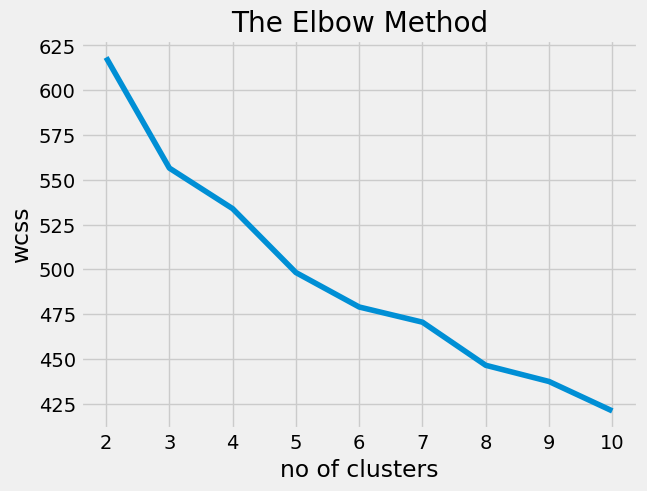

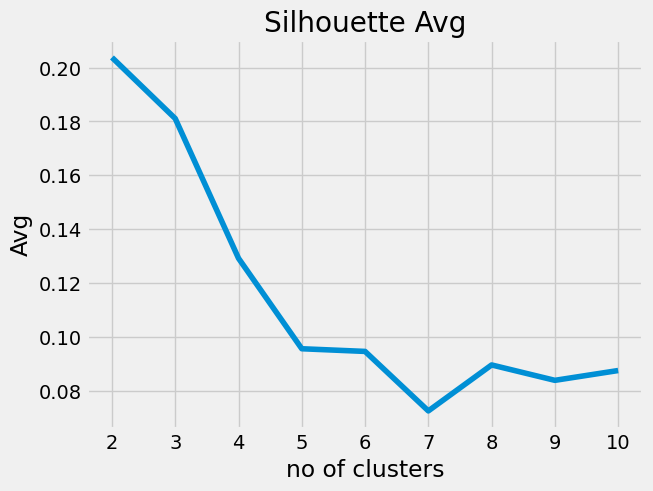

[618.3058823529411, 556.5407170294495, 533.9044053985228, 498.2393260334436, 479.00431363768075, 470.5343964858671, 446.47179271708694, 437.43001443001435, 421.0050132873662]
[0.20372916614245037, 0.18107601034944756, 0.1292614068968516, 0.09572270044923478, 0.09473233395322231, 0.07267433242292565, 0.0897169506979365, 0.08400997968437413, 0.08764759012885001]


In [292]:
benchmark_K_means(behavioral_data, 11)

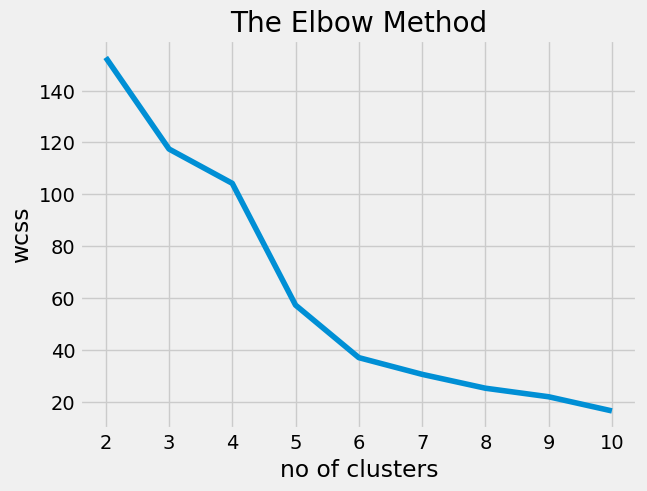

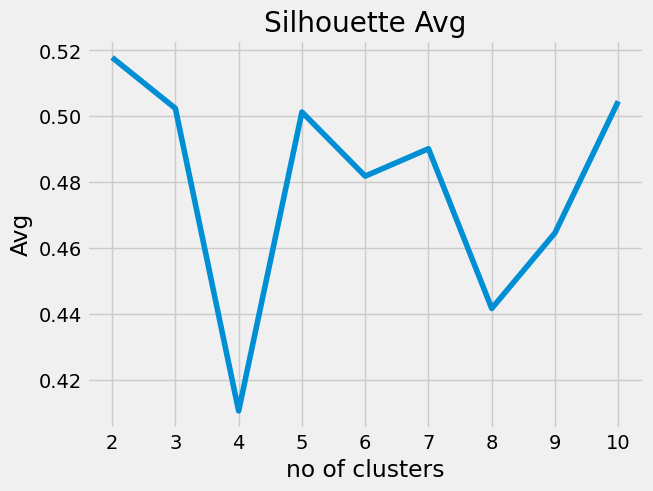

[152.72674565050949, 117.47169751154706, 104.24867010878606, 57.3639326674943, 37.13376501437639, 30.704727637348782, 25.36243089260593, 22.068117400617727, 16.620293823185992]
[0.5178851297278549, 0.5024259815951772, 0.4105689079613848, 0.5013202708908696, 0.4818534543729085, 0.49017911479418835, 0.4416783836674561, 0.4646291154174567, 0.5045712832200703]


In [293]:
pca = PCA(n_components=2)
reduced_behavioral_data = pca.fit_transform(behavioral_data)

benchmark_K_means(reduced_behavioral_data, 11)

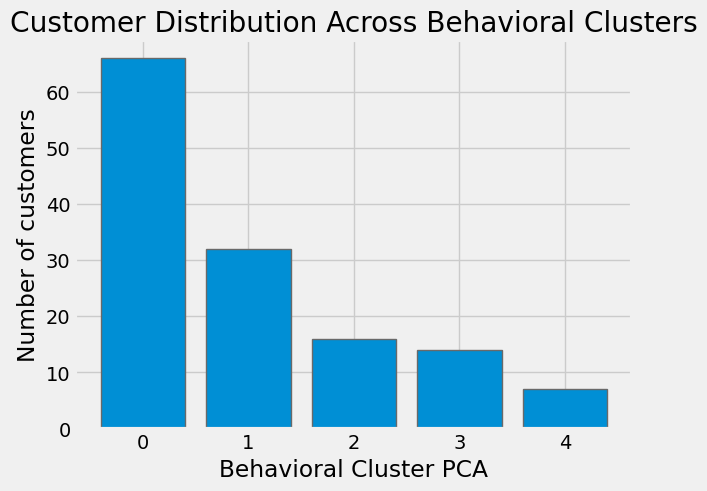

In [294]:
N_CLUSTERS = 5

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=4, n_init="auto")  # Adjust the number of clusters based on your analysis
behavioral_data["Behavioral Cluster PCA"] = kmeans.fit_predict(reduced_behavioral_data)

# 1. Distribution of customers across clusters
plt.bar([f"{i}" for i in range(N_CLUSTERS)], behavioral_data["Behavioral Cluster PCA"].value_counts())
plt.xlabel("Behavioral Cluster PCA")
plt.ylabel("Number of customers")
plt.title("Customer Distribution Across Behavioral Clusters")
plt.show()

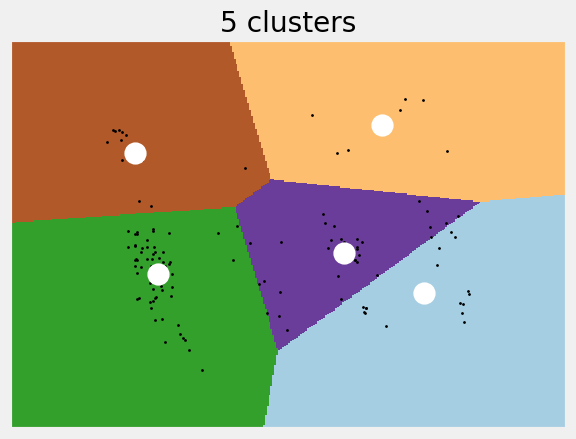

In [295]:
cluster_area_plot(reduced_behavioral_data, kmeans, N_CLUSTERS)

In [296]:
data['Demographic Segement'] = demographic_data["Demographic Cluster PCA"]
data['Psychographic Segement'] = psychographic_data["Psychographic Cluster PCA"]
data['Technographic Segment'] = technographic_data["Technographic Cluster PCA"]
data['Behavioral Segment'] = behavioral_data["Behavioral Cluster PCA"]

In [297]:
data

,Age,Gender,Occupation,Location,Shopping Frequency,"Online, instore preferences",Brand Preference,Likeliness of Promotion or Discount,Average Spent,Types of Clothing_Casual Wear,...,Communication Methods_Leaflets,Communication Methods_Email newsletters,Payment Methods_Cash,Payment Methods_Credit/Debit Card,Payment Methods_Mobile Payment Apps,Payment Methods_Online Payment Platforms,Demographic Segement,Psychographic Segement,Technographic Segment,Behavioral Segment
0,0,0,4,0,3,3,0,3,0,1,...,0,0,1,0,0,0,1,4,7,4
1,0,0,4,0,2,0,1,3,2,1,...,1,0,0,1,0,0,1,0,0,0
2,0,0,4,6,2,0,0,5,2,1,...,0,1,1,0,0,0,0,0,6,3
3,0,0,4,6,3,1,0,4,0,1,...,0,0,1,1,0,0,0,2,5,2
4,1,0,2,0,1,0,0,5,3,1,...,0,1,0,1,0,0,3,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0,0,4,0,2,3,1,5,2,1,...,0,1,0,1,0,0,1,1,4,1
131,0,0,4,6,1,1,0,5,2,1,...,0,0,1,0,0,0,0,3,5,3
132,0,0,4,4,2,3,0,4,2,1,...,0,0,1,1,1,1,0,1,7,1
133,0,1,0,5,1,0,0,4,0,1,...,1,0,1,1,0,0,2,2,6,2
